In [73]:
import pickle
with open('./dict_data_olsson.pkl', 'rb') as fp:
    dict_data_olsson = pickle.load(fp)
    
with open('./dict_data_paul.pkl', 'rb') as fp:
    dict_data_paul = pickle.load(fp)
    
with open('./dict_data_planaria.pkl', 'rb') as fp:
    dict_data_planaria = pickle.load(fp)

In [74]:
from lib.dataset import binary_tree
from lib import functions
from lib.dataset.binary_tree import *
import hdbscan
from sklearn.cluster import DBSCAN
import time

import itertools
import numpy
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot

from math import inf


# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None]
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
	return normalized(numpy.cross(A, B) + numpy.cross(B, C) + numpy.cross(C, A))



def get_power_circumcenter(A, B, C):
	N = get_triangle_normal(A, B, C)
	return (-.5 / N[2]) * N[:2]



def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_power_triangulation(S, R):
	# Compute the lifted weighted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R #instead of ...-R**2, because error in the paper where the formula gives R**2 and not R 
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
		else:
			return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

	# Compute the convex hull of the lifted weighted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull
	tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
	
	# Compute the Voronoi points
	V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

	# Job done
	return tri_list, V



# --- Compute Voronoi cells ---------------------------------------------------

'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
def get_voronoi_cells(S, V, tri_list):
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))
    #print('vertices_set:', vertices_set)

    # Keep track of which edge separate which triangles
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]
    #print('edge_map:', edge_map)

    # For each triangle
    voronoi_cell_map = { i : [] for i in vertices_set }
    #print('voronoi_cell_map before big loop:', voronoi_cell_map)

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        #print('i:', i)
        #print('(a, b, c):', (a, b, c))
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
        # Finite Voronoi edge
            #print('u:', u) 
            #print('v:', v) 
            #print('w:', w)
            edge = tuple(sorted((u, v)))
            #print('edge:', edge)
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j
                
                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
                #print('voronoi_cell_map[u]:', voronoi_cell_map[u])
            else: 
            # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + numpy.dot(D - A, U) * U
                W = normalized(I - D)
                if numpy.dot(W, I - C) < 0:
                    W = -W
            
                # Add the segment
                voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))
                voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))

    #print('voronoi_cell_map after big loop:', voronoi_cell_map)
    
    # Order the segments
    def order_segment_list(segment_list):
        # Pick the first element
        first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

        # In-place ordering
        segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
        for i in range(len(segment_list) - 1):
            for j in range(i + 1, len(segment_list)):
                if segment_list[i][0][1] == segment_list[j][0][0]:
                    segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                    break

        # Job done
        return segment_list

    # Job done
    return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }




def display(S, R, tri_list, voronoi_cell_map, true_edges=None, margen=0, points=None, title='Voronoi diagram and Delaunay complex'):
    # Setup
    #fig, ax = plot.subplots()
    fig, ax = plot.subplots(figsize = (50, 50))
    plot.axis('equal')
    plot.axis('off')
    #plot.scatter(S[:, 0], S[:, 1], s=20, c='black')
    #plot.scatter(points[:, 0], points[:, 1], s=100, c=L, cmap='Spectral')
    plot.scatter(points[:, 0], points[:, 1], s=100)

    # Set min/max display size, as Matplotlib does it wrong
    min_corner_x = numpy.amin(S, axis = 0)-margen #- numpy.max(R)
    max_corner_x = numpy.amax(S, axis = 0)+margen #+ numpy.max(R)
    min_corner_y = numpy.amin(S, axis = 1)-margen #- numpy.max(R)
    max_corner_y = numpy.amax(S, axis = 1)+margen #+ numpy.max(R)
    plot.xlim((min_corner_x[0], max_corner_x[0]))
    plot.ylim((min_corner_y[1], max_corner_y[1]))

    # Plot the samples
    for Si, Ri in zip(S, R):             #fill = True
        ax.add_artist(plot.Circle(Si, Ri, fill = False, alpha = .1, lw = 0., color = '#8080f0', zorder = 1))

    # Plot the power triangulation
    edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
    line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = 'green')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # Plot the Voronoi cells
    edge_map = { }
    for segment_list in voronoi_cell_map.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is None:
                    tmax = 10
                if tmin is None:
                    tmin = -10

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    line_list = LineCollection(edge_map.values(), lw = 1., colors = 'red')
    line_list.set_zorder(0)
    ax.add_collection(line_list)
    
    if true_edges != None:
        line_list = LineCollection([(S[i], S[j]) for i, j in true_edges], lw = 15., colors = 'grey', alpha=0.4)
        line_list.set_zorder(0)
        ax.add_collection(line_list)
    
    ax.add_artist(plot.Circle((0.0, 0.0), 1.0, fill = False, lw = 1., color = 'black'))

    # Job done
    plot.title(title)
    plot.show()
    
#--- Utils------------------------

def hamming_distance(x, y):
    return (x.astype(np.int32) ^ y.astype(np.int32)).sum()

def distance_beltrami(p,q): #with p and q in euclidean coordinates and their norm<1
    return np.arccosh((1-np.dot(p,q))/np.sqrt((1-np.linalg.norm(p)**2)*(1-np.linalg.norm(q)**2)))  
    
def build_tree_geodesic_distance_matrix(original_tree):    
    tree_geodesic_distance_matrix = np.zeros((original_tree.shape[0], original_tree.shape[0]))   
    for i in range(tree_geodesic_distance_matrix.shape[0]):
        for j in range(tree_geodesic_distance_matrix.shape[1]):
            tree_geodesic_distance_matrix[i][j] = hamming_distance(original_tree[i], original_tree[j]) 
    return tree_geodesic_distance_matrix
        
def build_latent_hyperbolic_distance_matrix(z_normalized):     
    #latent_hyperbolic_distance_matrix = np.zeros((original_tree.shape[0], original_tree.shape[0]))  
    latent_hyperbolic_distance_matrix = np.zeros((z_normalized.shape[0], z_normalized.shape[0]))      
    for i in range(latent_hyperbolic_distance_matrix.shape[0]):
        #print('i: ', i)
        for j in range(latent_hyperbolic_distance_matrix.shape[1]):
            #print('i: ', i,', j: ',j)
            #print('j: ', j)
            if i==j: #to avoid computing and getting nan, since we know that d(i,i)=0
                latent_hyperbolic_distance_matrix[i][j] = 0.0
            else:
                latent_hyperbolic_distance_matrix[i][j] = distance_beltrami(z_normalized[i],z_normalized[j])
    #print('done')
    return latent_hyperbolic_distance_matrix

def build_hyperbolically_weighted_adjacency_matrix(edges, z_normalized):     
    hyperbolically_weighted_adjacency_matrix = np.zeros((z_normalized.shape[0], z_normalized.shape[0]))          
    for edge in edges:
        indices = []
        for i in edge:
            indices.append(i) 
        hyperbolically_weighted_adjacency_matrix[indices[0]][indices[1]] = distance_beltrami(z_normalized[indices[0]],z_normalized[indices[1]]) 
        hyperbolically_weighted_adjacency_matrix[indices[1]][indices[0]] = distance_beltrami(z_normalized[indices[1]],z_normalized[indices[0]]) 

    #print('done')
    return hyperbolically_weighted_adjacency_matrix

def build_binary_adjacency_matrix(edges, z_normalized):     
    binary_adjacency_matrix = np.zeros((z_normalized.shape[0], z_normalized.shape[0]))          
    for edge in edges:
        indices = []
        for i in edge:
            indices.append(i) 
        binary_adjacency_matrix[indices[0]][indices[1]] = 1.0 
        binary_adjacency_matrix[indices[1]][indices[0]] = 1.0

    #print('done')
    return binary_adjacency_matrix

#groundtruth tree edges
def build_true_edges(tree_geodesic_distance_matrix):
    true_edges = set()
    for i in range(tree_geodesic_distance_matrix.shape[0]):
        for j in range(tree_geodesic_distance_matrix.shape[1]):
            if tree_geodesic_distance_matrix[i][j]==1.:
                temp=frozenset({i, j})
                true_edges.add(temp) 
    return true_edges

def build_edges(distance_matrix):
    edges = set()
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            if distance_matrix[i][j]>0.:
                temp=frozenset({i, j})
                edges.add(temp) 
    return edges

def convert_tri_list_to_edges(tri_list):
    edges = set()
    for l in tri_list:
        edges.add( frozenset({l[0], l[1]}) )
        edges.add( frozenset({l[1], l[2]}) )
        edges.add( frozenset({l[2], l[0]}) )
    return edges

#############
################
#####################
##############
##########
def get_edge_map(tri_list):    
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            #print(edge)
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]  
    return edge_map
    
def convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map):
    tri_list_real = []
    V_real = []
    edges_real = set()
    number_of_delaunay_edges_corresponding_to_halflines = 0
    for i,triangle in enumerate(tri_list):
        if np.linalg.norm(V[i]) < 1:
            edges_real.add( frozenset({triangle[0], triangle[1]}) )
            edges_real.add( frozenset({triangle[1], triangle[2]}) )
            edges_real.add( frozenset({triangle[2], triangle[0]}) )            
        else:
            triangle_edges = [tuple(sorted((triangle[0], triangle[1]))), tuple(sorted((triangle[1], triangle[2]))), tuple(sorted((triangle[2], triangle[0]))) ]
            for triangle_edge in triangle_edges:
                #print('triangle_edge:', triangle_edge)
                associated_triangles = edge_map[tuple(triangle_edge)] # all the triangles from which triangle_edge is an edge, should be 2 triangles in general, but 1 triangle for some cases   
                #print('associated_triangles:', associated_triangles)
                if len(associated_triangles)==2:
                    if min(np.linalg.norm(V[associated_triangles[0]]), np.linalg.norm(V[associated_triangles[1]]))<1:    
                        #print('One Voronoi point is outside and the other inside the unit disk.')
                        edges_real.add( frozenset({triangle_edge[0], triangle_edge[1]}) )
                    else: #that is: the two associated voronoi points (end points of the voronoi segment which is the dual of the delaunay edge) are outside the unit disk, then if the line intersect the unit disk and the intersections belong to the voronoi segment then the corresponding delaunay edge should be kept
                        #print('The two Voronoi points are outside the unit disk.')
                        m = ( V[associated_triangles[1]][1]-V[associated_triangles[0]][1] ) / ( V[associated_triangles[1]][0]-V[associated_triangles[0]][0] ) #coeff directeur de la droite passant par les voronoi points                    
                        p = V[associated_triangles[0]][1] - m*V[associated_triangles[0]][0] #ordonnée à l'origine
                        delta = 4*(m**2-p**2+1)
                        if delta>0: #that is if the line interects the cirlce at two places
                            #print('The line passing through the two Voronoi points is intersecting the disk.')
                            a = (1+m**2)
                            b = 2*m*p
                            c = p**2-1 
                            sol1_x = (-b-np.sqrt(delta))/(2*a)
                            sol2_x = (-b+np.sqrt(delta))/(2*a)
                            sol1_y = m*sol1_x+p
                            sol2_y = m*sol2_x+p
                            min_voronoi_x = min(V[associated_triangles[0]][0], V[associated_triangles[1]][0])
                            max_voronoi_x = max(V[associated_triangles[0]][0], V[associated_triangles[1]][0])       
                            min_voronoi_y = min(V[associated_triangles[0]][1], V[associated_triangles[1]][1]) 
                            max_voronoi_y = max(V[associated_triangles[0]][1], V[associated_triangles[1]][1])
                            if ( min_voronoi_x<=min(sol1_x,sol2_x) ) and ( max_voronoi_x>=max(sol1_x,sol2_x) ) and ( min_voronoi_y<=min(sol1_y,sol2_y) ) and ( max_voronoi_y>=max(sol1_y,sol2_y) ):
                                #print('The two intersections points belong to the Voronoi segment.')
                                edges_real.add( frozenset({triangle_edge[0], triangle_edge[1]}) )
                            #edges_real.add( frozenset({triangle_edge[0], triangle_edge[1]}) )
                        #else:
                            #print('The line passing through the two Voronoi points is not intersecting the disk, or is tangent to it.')
                elif len(associated_triangles)==1: #i.e. delaunay edge is the edge of only one triangle, i.e. the corresponding voronoi edge is a half-line starting from one voronoi point
                    #print('This is a half-line')
                    #if half-line intersects the unit circle then we keep it
#                     print('triangle_edge:', triangle_edge)
#                     print('i:', i)
#                     print('V[i]:', V[i])
#                     print('voronoi_cell_map[triangle_edge[0]]:', voronoi_cell_map[triangle_edge[0]])
#                     print('voronoi_cell_map[triangle_edge[1]]:', voronoi_cell_map[triangle_edge[1]])
                    for triangle_edge_index in [0,1]:
                        for border in voronoi_cell_map[triangle_edge[triangle_edge_index]]:
                            #print('border', border)
                            if border[0]==(i, -1): #half-line border from the i-th Voronoi point to infinite
#                                 print('The border (i, -1) is:', border)
#                                 print('V[i]:', V[i])
                                U = border[1][1] #unit vector direction of the half-line from Voronoi point to infinite
                                radial = -border[1][0] #border[1][0] should be equal to array(V[i])  
                                radial = radial/np.linalg.norm(radial) #unit vector direction from Voronoi point to origin of the Klein-Beltrami disk (center of the unit disk)
                                theta = np.arccos(np.dot(U,radial))
                                alpha = np.arcsin(1/np.linalg.norm(V[i])) #alpha is the limit angle for when the half-line is tangent to the unit circle
#                                 print('U', U)
#                                 print('radial', radial)
#                                 print('theta', theta)
#                                 print('alpha', alpha)
                                if theta<alpha or theta>(2*np.pi - alpha): #i.e. the half-line intersects the unit circle
                                    edges_real.add( frozenset({triangle_edge[0], triangle_edge[1]}) )
                                    number_of_delaunay_edges_corresponding_to_halflines +=1
#                                     print('The half-line intersects the unit circle.')
#                                 else:
#                                     print('The half-line does not intersect the unit circle.')                 
#     print('Number of Delaunay edges corresponding to half-lines:', number_of_delaunay_edges_corresponding_to_halflines)                                    
    return edges_real
                
#voronoi_cell_map[point data i.e. triangle_edge[0]][the border having (-1, i) or (i, -1)][1][1]    


#                     m = U[1]/U[0]
#                     p = V[associated_triangles[0]][1] - m*V[associated_triangles[0]][0] #ordonnée à l'origine
#                     delta = 4*(m**2-p**2+1)
#                     if delta>0: #that is if the line interects the cirlce at two places
#                         #print('The line passing through the two Voronoi points is intersecting the disk.')
#                         a = (1+m**2)
#                         b = 2*m*p
#                         c = p**2-1 
#                         sol1_x = (-b-np.sqrt(delta))/(2*a)
#                         sol2_x = (-b+np.sqrt(delta))/(2*a)
#                         sol1_y = m*sol1_x+p
#                         sol2_y = m*sol2_x+p 


################
###########
####
##

def sets_ratio(set1, set2):   
    set1_in_set2 = 0
    for edge in set1:
        if {edge}.issubset(set2):
            set1_in_set2+=1
    print('Number of edges of set1 also in set2: ', set1_in_set2)
    return set1_in_set2/len(set2)

###def true_edges_ratio(edges, true_edges=true_edges):
def true_edges_ratio(edges, true_edges):
    #print('len(true_edges): ', len(true_edges))
    #print('len(edges_filtered_closest): ', len(edges_filtered_closest))
    intersection = true_edges.intersection(edges)
    #print('len(intersection): ', len(intersection))
    #print('len(intersection)/len(true_edges): ', len(intersection)/len(true_edges))
    external_true_edges_ratio = len(intersection)/len(true_edges) #This gives the ratio of how many true edges of the graph are recovered w.r.t. the groundtruth true edges.
    print('The external_true_edges_ratio=len(intersection)/len(true_edges) is:', external_true_edges_ratio)
    internal_true_edges_ratio = len(intersection)/len(edges) #This gives the ratio of true edges in this graph among edges of this same graph.
    print('The internal_true_edges_ratio=len(intersection)/len(edges) is:', internal_true_edges_ratio) 
    return [external_true_edges_ratio, internal_true_edges_ratio]

def edges_hamming_score(edges): #Should be 1 if only true edges, i.e. edges which are also edges in the original tree
    score = 0
    for e in edges:
        vertex1, vertex2 = e
        score = score + hamming_distance(original_tree[vertex1], original_tree[vertex2])
    score = score/len(edges)
    print('The hamming score is:', score)
    return score
   
def edges_filtering_two_closest(edges):
    edges_copy = edges.copy()
    edges_filtered_closest = set()
    #leafs = [0]
    leafs = [0, 1]
    explored_leafs = []
    c = 0
    while c<1:
        #print('start', c)
        #print('leafs:', leafs)
        for vertex in leafs:
            leafs.remove(vertex)
            #print('current leaf:', vertex)
            #current_best_neighbours = [[99999, 1], [99998, 1]] #[[index,value],..]
            current_best_neighbours = []
            seen_edges = []
            for edge in edges_copy: 
                if vertex in edge:
                    seen_edges.append(edge)
                    for v in edge:
                        if v!=vertex and v not in explored_leafs and v not in leafs:
                            potential_neighbour = v 
                            #print('potential_neighbour:', potential_neighbour)
                            if len(current_best_neighbours)<2:
                                current_best_neighbours.append([potential_neighbour, distance_beltrami(z_normalized[vertex], z_normalized[potential_neighbour])])
                            else:
                                if current_best_neighbours[0][1]>current_best_neighbours[1][1]:
                                    current_max_index, current_max_value = current_best_neighbours[0][0], current_best_neighbours[0][1]
                                else:
                                    current_max_index, current_max_value = current_best_neighbours[1][0], current_best_neighbours[1][1]                      
                                dist = distance_beltrami(z_normalized[vertex], z_normalized[potential_neighbour])
                                if dist < current_max_value:
                                    current_best_neighbours.remove([current_max_index, current_max_value])
                                    current_best_neighbours.append([potential_neighbour, dist])
            #print('current_best_neighbours', current_best_neighbours)
            for edge in seen_edges:
                edges_copy.remove(edge)
            if len(current_best_neighbours)>0:
                if len(current_best_neighbours)==1:
                    edges_filtered_closest.add(frozenset({vertex, current_best_neighbours[0][0]}))
                    leafs.append(current_best_neighbours[0][0])
                else:
                    edges_filtered_closest.add(frozenset({vertex, current_best_neighbours[0][0]}))
                    edges_filtered_closest.add(frozenset({vertex, current_best_neighbours[1][0]}))
                    leafs.append(current_best_neighbours[0][0])
                    leafs.append(current_best_neighbours[1][0])
            #print('edges_filtered_closest:', edges_filtered_closest)
            explored_leafs.append(vertex)
        #print(len(leafs))
        if len(leafs) == 0:
            c +=1
        #print('end', c)
    return edges_filtered_closest

def midpoint_hyperbolic_dichotomy(a, b, epsilon):
    a_new = a.copy()
    b_new = b.copy()
    midpoint = (a_new+b_new)/2
    err = distance_beltrami(a, midpoint)-distance_beltrami(b, midpoint)
    while np.abs(err) > epsilon:
        if err > 0:
            a_new = a_new
            b_new = midpoint
            midpoint = (a_new+b_new)/2
        else:
            a_new = midpoint
            b_new = b_new
            midpoint = (a_new+b_new)/2
        err = distance_beltrami(a, midpoint)-distance_beltrami(b, midpoint)
    return midpoint

def gabriel_wrong_from_delaunay(edges_delaunay, z_encodings):
    edges_gabriel = set()
    for edge in edges_delaunay:
        #print('edge', edge)
        vertices = []
        for vertex in edge:
            vertices.append(vertex)
        vertex1 = vertices[0]
        vertex2 = vertices[1] 
        #edge_distance = distance_beltrami(z_encodings[vertex1], z_encodings[vertex2])
        midpoint = (z_encodings[vertex1] + z_encodings[vertex2])/2 # Not the hyperbolic midpoint!  
        exit=0
        for i in range(z_encodings.shape[0]):
            if i!=vertex1 and i!=vertex2:
                if distance_beltrami(midpoint, z_encodings[i])< max(distance_beltrami(midpoint, z_encodings[vertex1]), distance_beltrami(midpoint, z_encodings[vertex2])):
                    exit+=1
                    #print('distance_beltrami(midpoint, z)', distance_beltrami(midpoint, z_encodings[i]))
                    #print('max(dist_beltrami1, dist_beltrami1)', max(distance_beltrami(midpoint, z_encodings[vertex1]), distance_beltrami(midpoint, z_encodings[vertex2])))
                    break
        #print('exit', exit)
        if exit==0:
            edges_gabriel.add(edge)
    return edges_gabriel

def gabriel_from_delaunay(edges_delaunay, z_encodings, epsilon):
    edges_gabriel = set()
    for edge in edges_delaunay:
        #print('edge', edge)
        vertices = []
        for vertex in edge:
            vertices.append(vertex)
        vertex1 = vertices[0]
        vertex2 = vertices[1] 
        midpoint = midpoint_hyperbolic_dichotomy(z_encodings[vertex1], z_encodings[vertex2], epsilon) #Approximated hyperbolic midpoint        exit=0
        exit=0
        for i in range(z_encodings.shape[0]):
            if i!=vertex1 and i!=vertex2:
                if distance_beltrami(midpoint, z_encodings[i])< max(distance_beltrami(midpoint, z_encodings[vertex1]), distance_beltrami(midpoint, z_encodings[vertex2])):
                    exit+=1
                    #print('distance_beltrami(midpoint, z)', distance_beltrami(midpoint, z_encodings[i]))
                    #print('max(dist_beltrami1, dist_beltrami1)', max(distance_beltrami(midpoint, z_encodings[vertex1]), distance_beltrami(midpoint, z_encodings[vertex2])))
                    break
        #print('exit', exit)
        if exit==0:
            edges_gabriel.add(edge)
    return edges_gabriel

#####################################################
#####################################################

import numpy as np
from matplotlib import pyplot as plt
import random
random.seed(0)
np.random.seed(0)

In [75]:
def hyperbolic_cdist(A,B): #Compute (Beltrami) hyperbolic distance between each pair of the two collections of inputs.
    hyperbolic_cdist = np.zeros((A.shape[0], B.shape[0])) 
    for i in range(hyperbolic_cdist.shape[0]): 
        for j in range(hyperbolic_cdist.shape[1]):
            hyperbolic_cdist[i][j] = distance_beltrami(A[i], B[j])
            #print(hyperbolic_cdist[i][j])
    return hyperbolic_cdist

def hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdist):
    row_ind, col_ind = linear_sum_assignment(hyperbolic_cdist)
    hyperbolic_Wasserstein_dist = hyperbolic_cdist[row_ind, col_ind].sum()       #mean and normalize to be between 0 and 1
    return hyperbolic_Wasserstein_dist

def hyperbolic_Chamfer_dist(A,B, hyperbolic_cdist): #symmetrized Chamfer distance
    c_dist_square = hyperbolic_cdist ** 2

    # Find the minimum squared distance along last axis
    #Example for a NxP distance matrix, gives a vector of N elements: for each of the N rows of the NxP matrix, gives the minimal value between the P values. i.e. for each point of the first set, it gives the distance of the closest point from the other set. 
    min_squared_dist_a = np.min(c_dist_square, axis=-1)
    # Take the mean
    average_min_squared_dist_a = np.mean(min_squared_dist_a, axis=-1)    
    
    # Find the minimum squared distance along first axis
    min_squared_dist_b = np.min(c_dist_square, axis=0) #mistake corrected, I had axis=1 instead of axis=0, thanks Vlad!
    # Take the mean along last axis
    average_min_squared_dist_b = np.mean(min_squared_dist_b, axis=-1)
    
    return (average_min_squared_dist_a + average_min_squared_dist_b)/2

def hyperbolic_Hausdorff_dist(A,B, hyperbolic_cdist):

    c_dist_square = hyperbolic_cdist ** 2
    
    # Find the minimum distance along last axis
    #Example for a NxP distance matrix, gives a vector of N elements: for each of the N rows of the NxP matrix, gives the minimal value between the P values. i.e. for each point of the first set, it gives the distance of the closest point from the other set. 
    dist_a = np.min(c_dist_square, axis=-1)
    # Take the max
    max_dist_a = np.max(dist_a, axis=-1)    
    
    # Find the minimum distance along first axis
    dist_b = np.min(c_dist_square, axis=0)
    # Take the max along last axis
    max_dist_b = np.max(dist_b, axis=-1)
    
    return max(max_dist_a, max_dist_b)

#####################################################3


def distillation(delaunay, cluster_labels): #input delaunay is a set of frozensets, and cluster_labels an array with the cluster label for each point
    
    distilled_delaunay = {}
    for label in sorted(set(cluster_labels)):
        distilled_delaunay[label] = set()
    crossed_edges = set()
    
    for edge in delaunay:
        (v0,v1) = edge
        if cluster_labels[v0]==cluster_labels[v1]:
            distilled_delaunay[cluster_labels[v0]].add(edge)
        else:
            crossed_edges.add(edge)
    
    return {'distilled_delaunay': distilled_delaunay, 'crossed_edges': crossed_edges}

#################################################

def eval_scores_dca_local(distilled_delaunay, cluster_labels, R_indices, E_indices, get_edges_family = False):

    if get_edges_family == True:
        edges_family = {'intracluster': {'RR':set(), 'EE':set(), 'RE_U_ER':set()}, 'intercluster': {'RR':set(), 'EE':set(), 'RE_U_ER':set()}}
    
    scores_local = {}
    for label in distilled_delaunay.keys():
        scores_local[label] = {'cardRvertices':0, 'cardEvertices':0, 'cardRedges':0, 'cardEedges':0, 'card_edges':0, 'consistency':[], 'quality': []}

    for R_index in R_indices:
        scores_local[cluster_labels[R_index]]['cardRvertices']+=1
    for E_index in E_indices:
        scores_local[cluster_labels[E_index]]['cardEvertices']+=1

    for label in distilled_delaunay.keys():
        for (v0,v1) in distilled_delaunay[label]:
            scores_local[label]['card_edges']+=1
            if (v0 in E_indices) and (v1 in E_indices):
                scores_local[label]['cardEedges']+=1
                if get_edges_family == True: edges_family['intracluster']['EE'].add((v0,v1))
            elif (v0 in R_indices) and (v1 in R_indices):
                scores_local[label]['cardRedges']+=1
                if get_edges_family == True: edges_family['intracluster']['RR'].add((v0,v1))
            else:
                if get_edges_family == True: edges_family['intracluster']['RE_U_ER'].add((v0,v1))
                

    for label in distilled_delaunay.keys():
        scores_local[label]['consistency'] = 1 - abs(scores_local[label]['cardRvertices']-scores_local[label]['cardEvertices'])/(scores_local[label]['cardRvertices']+scores_local[label]['cardEvertices'])

        if scores_local[label]['card_edges']>=1:
            scores_local[label]['quality'] = 1 - (scores_local[label]['cardRedges']+scores_local[label]['cardEedges'])/scores_local[label]['card_edges']

    if get_edges_family == True:
        return scores_local, edges_family
    else:
        return scores_local
    
############################################


def get_fundamental_components(scores_dca_local, eta_c, eta_q):
    fundamental_components = []
    for label in scores_dca_local.keys():
        if scores_dca_local[label]['consistency']>eta_c and scores_dca_local[label]['quality']>eta_q:
            fundamental_components.append(label)
    return fundamental_components

#######################################


def eval_scores_dca_global(scores_dca_local, eta_c, eta_q, R_indices, E_indices, crossed_edges, delaunay, edges_family=None, get_edges_family=False):
    
    fundamental_components = get_fundamental_components(scores_dca_local, eta_c, eta_q)
    
    precision = 0
    recall = 0
    for i in fundamental_components:
        precision += scores_dca_local[i]['cardEvertices']
        recall += scores_dca_local[i]['cardRvertices']
    precision = precision / len(E_indices)
    recall = recall / len(R_indices)
    
#     #DCA's original paper consistency global score according to their definition 3.3, but this would just give 1 if card(R)=card(E)...
#     consistency = 1 - abs(len(R_indices)-len(E_indices))/(len(R_indices)+len(E_indices))
    
    #So we redefine the consistency global score as: weighted average of the consistency local scores. Weighted by the number of vertices in each cluster. 
    consistency = 0
    total_number_considered_vertices = 0
    for i in scores_dca_local.keys():
        consistency += scores_dca_local[i]['consistency']*(scores_dca_local[i]['cardRvertices']+scores_dca_local[i]['cardEvertices'])
        total_number_considered_vertices += scores_dca_local[i]['cardRvertices']+scores_dca_local[i]['cardEvertices']
    consistency = consistency/total_number_considered_vertices
    
    card_crossed_edges_in_RR_or_EE = 0
    if get_edges_family == False:
        for (v0,v1) in crossed_edges:
            if ( (v0 in E_indices) and (v1 in E_indices) ) or ( (v0 in R_indices) and (v1 in R_indices) ):
                card_crossed_edges_in_RR_or_EE+=1
    else:
        for (v0,v1) in crossed_edges:
            if v0 in E_indices:
                if v1 in E_indices: #EE
                    card_crossed_edges_in_RR_or_EE+=1
                    edges_family['intercluster']['EE'].add((v0,v1))
                else: #ER
                    edges_family['intercluster']['RE_U_ER'].add((v0,v1))
            elif v1 in R_indices: #RR
                card_crossed_edges_in_RR_or_EE+=1
                edges_family['intercluster']['RR'].add((v0,v1))
            else: #RE
                edges_family['intercluster']['RE_U_ER'].add((v0,v1))
                
    
    card_noncrossed_edges_in_RR_or_EE = 0
    for label in scores_dca_local.keys():
        card_noncrossed_edges_in_RR_or_EE+= scores_dca_local[label]['cardRedges']+scores_dca_local[label]['cardEedges']
    
    card_edges_delaunay = len(delaunay)
    if card_edges_delaunay < 1:
        quality = 0
    else:
        quality = 1 - (card_noncrossed_edges_in_RR_or_EE+card_crossed_edges_in_RR_or_EE)/card_edges_delaunay
        #Note: card_noncrossed_edges_in_RR_or_EE+card_crossed_edges_in_RR_or_EE = card_edges_in_RE_or_ER = number of heterogeneous edges
    
    
    if get_edges_family == True:
        return {'precision': precision, 'recall': recall, 'consistency': consistency, 'quality': quality}, edges_family
    else:
        return {'precision': precision, 'recall': recall, 'consistency': consistency, 'quality': quality}
    
####################

In [76]:
def visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0, title='Hyperbolic DCA visualization'): 
    # Setup
    #fig, ax = plot.subplots()
    fig, ax = plot.subplots(figsize = (20, 20)) #20 #10 #100
    plot.axis('equal')
    plot.axis('off')
    point_size=10#0.5
#     for i in R_indices[1:]:
#         plot.scatter(S[i, 0], S[i, 1], s=point_size, c='blue')
#     for i in E_indices[1:]:
#         plot.scatter(S[i, 0], S[i, 1], s=point_size, c='orange')
#     plot.scatter(S[R_indices[0], 0], S[R_indices[0], 1], s=point_size, c='blue', label='R')
#     plot.scatter(S[E_indices[0], 0], S[E_indices[0], 1], s=point_size, c='orange', label='E')



# #Neoblasts versus differentiated, Neoblasts versus progenitors:
#     # Set min/max display size, as Matplotlib does it wrong
#     min_corner_x = numpy.amin(S, axis = 0)-0.1 #- numpy.max(R)
#     max_corner_x = numpy.amax(S, axis = 0)+0.1 #+ numpy.max(R)
#     min_corner_y = numpy.amin(S, axis = 1)-0.7#+0.9#-0.1 #- numpy.max(R)
#     max_corner_y = numpy.amax(S, axis = 1)+0.55 #+ numpy.max(R)
#     plot.xlim((min_corner_x[0], max_corner_x[0]))
#     plot.ylim((min_corner_y[1], max_corner_y[1]))
    
# #Progenitors versus differentiated:
#     # Set min/max display size, as Matplotlib does it wrong
#     min_corner_x = numpy.amin(S, axis = 0)-0.1 #- numpy.max(R)
#     max_corner_x = numpy.amax(S, axis = 0)+0.1 #+ numpy.max(R)
#     min_corner_y = numpy.amin(S, axis = 1)-0.6#+0.9#-0.1 #- numpy.max(R)
#     max_corner_y = numpy.amax(S, axis = 1)+1.1 #+ numpy.max(R)
#     plot.xlim((min_corner_x[0], max_corner_x[0]))
#     plot.ylim((min_corner_y[1], max_corner_y[1]))

# #Paul 7MEPVS13Baso and 7MEPVS14Mo:
#     # Set min/max display size, as Matplotlib does it wrong
#     min_corner_x = numpy.amin(S, axis = 0)-0.1 #- numpy.max(R)
#     max_corner_x = numpy.amax(S, axis = 0)+0.1 #+ numpy.max(R)
#     min_corner_y = numpy.amin(S, axis = 1)-0.8#+0.9#-0.1 #- numpy.max(R)
#     max_corner_y = numpy.amax(S, axis = 1)+0.7 #+ numpy.max(R)
#     plot.xlim((min_corner_x[0], max_corner_x[0]))
#     plot.ylim((min_corner_y[1], max_corner_y[1]))
    
    
# # ECML_exp3_Paul_13BasoVS14Mo
#     # Set min/max display size, as Matplotlib does it wrong
#     min_corner_x = numpy.amin(S, axis = 0)-0.4 #- numpy.max(R)
#     max_corner_x = numpy.amax(S, axis = 0)+0.4 #+ numpy.max(R)
#     min_corner_y = numpy.amin(S, axis = 1)-0.8#+0.9#-0.1 #- numpy.max(R)
#     max_corner_y = numpy.amax(S, axis = 1)+0.7 #+ numpy.max(R)
#     plot.xlim((min_corner_x[0], max_corner_x[0]))
#     plot.ylim((min_corner_y[1], max_corner_y[1]))

# # ECML_exp3_Olsson HSPC vs Mono and HSPC vs Gran
#     # Set min/max display size, as Matplotlib does it wrong
#     min_corner_x = numpy.amin(S, axis = 0)-0.4 #- numpy.max(R)
#     max_corner_x = numpy.amax(S, axis = 0)+0.4 #+ numpy.max(R)
#     min_corner_y = numpy.amin(S, axis = 1)-0.4#+0.9#-0.1 #- numpy.max(R)
#     max_corner_y = numpy.amax(S, axis = 1)+0.2 #+ numpy.max(R)
#     plot.xlim((min_corner_x[0], max_corner_x[0]))
#     plot.ylim((min_corner_y[1], max_corner_y[1]))
    
# ECML_exp3_Olsson Mono vs Gran
    # Set min/max display size, as Matplotlib does it wrong
    min_corner_x = numpy.amin(S, axis = 0)-0.8 #- numpy.max(R)
    max_corner_x = numpy.amax(S, axis = 0)+0.8 #+ numpy.max(R)
    min_corner_y = numpy.amin(S, axis = 1)-0.05#+0.9#-0.1 #- numpy.max(R)
    max_corner_y = numpy.amax(S, axis = 1)+1.1 #+ numpy.max(R)
    plot.xlim((min_corner_x[0], max_corner_x[0]))
    plot.ylim((min_corner_y[1], max_corner_y[1]))


    # Plot the Voronoi cells
    edge_map = { }
    for segment_list in voronoi_cell_map.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is None:
                    tmax = 10
                if tmin is None:
                    tmin = -10

                edge_map[edge] = (A + tmin * U, A + tmax * U)

#     line_list = LineCollection(edge_map.values(), lw = 1.0, colors = 'grey', linestyle='dashed', label='Voronoi cells')
#     line_list.set_zorder(0)
#     ax.add_collection(line_list)
    
#     if true_edges != None:
#         line_list = LineCollection([(S[i], S[j]) for i, j in true_edges], lw = 15., colors = 'grey', alpha=0.4)
#         line_list.set_zorder(0)
#         ax.add_collection(line_list)

    lw=1.0
    alpha_transparent_edges = 0.3 #0.25
    edges_intra_RR = LineCollection([(S[i], S[j]) for i, j in edges_family['intracluster']['RR']], lw = lw, colors = 'blue', alpha=1.0, label='intracluster RxR edge')
    edges_intra_RR.set_zorder(0)
    ax.add_collection(edges_intra_RR)

    edges_intra_EE = LineCollection([(S[i], S[j]) for i, j in edges_family['intracluster']['EE']], lw = lw, colors = 'orange', alpha=1.0, label='intracluster ExE edge')
    edges_intra_EE.set_zorder(0)
    ax.add_collection(edges_intra_EE)

    edges_intra_RE_U_ER = LineCollection([(S[i], S[j]) for i, j in edges_family['intracluster']['RE_U_ER']], lw = lw, colors = 'green', alpha=1.0, label='intracluster (RxE U ExR) edge')   
    edges_intra_RE_U_ER.set_zorder(0)
    ax.add_collection(edges_intra_RE_U_ER)

    edges_inter_RR = LineCollection([(S[i], S[j]) for i, j in edges_family['intercluster']['RR']], lw = lw, colors = 'blue', alpha=alpha_transparent_edges, label='intercluster RxR edge')
    edges_inter_RR.set_zorder(0)
    ax.add_collection(edges_inter_RR)

    edges_inter_EE = LineCollection([(S[i], S[j]) for i, j in edges_family['intercluster']['EE']], lw = lw, colors = 'orange', alpha=alpha_transparent_edges, label='intercluster ExE edge')
    edges_inter_EE.set_zorder(0)
    ax.add_collection(edges_inter_EE)

    edges_inter_RE_U_ER = LineCollection([(S[i], S[j]) for i, j in edges_family['intercluster']['RE_U_ER']], lw = lw, colors = 'green', alpha=alpha_transparent_edges, label='intercluster (RxE U ExR) edge')
    edges_inter_RE_U_ER.set_zorder(0)
    ax.add_collection(edges_inter_RE_U_ER)
    
#    ax.add_artist(plot.Circle((0.0, 0.0), 1.0, fill = False, lw = 1., color = 'black'))

    # Job done
    #plot.title(title)
    #leg=ax.legend(loc='lower right')
    
    plt.tight_layout(pad=0)

    #plot.savefig(title+'.pdf')
    #plot.savefig(title+'.png')
    
    
    
#     plot.savefig('ECML_exp3_Olsson_HSPC1VSMono.pdf')
#     plot.savefig('ECML_exp3_Olsson_HSPC1VSMono.png')

#     plot.savefig('ECML_exp3_Olsson_HSPC1VSGran.pdf')
#     plot.savefig('ECML_exp3_Olsson_HSPC1VSGran.png')

    plot.savefig('ECML_exp3_Olsson_MonoVSGran.pdf')
    plot.savefig('ECML_exp3_Olsson_MonoVSGran.png')
    
    
    
#     plot.savefig('ECML_exp3_Paul_7MEPVS13Baso.pdf')
#     plot.savefig('ECML_exp3_Paul_7MEPVS13Baso.png')

#     plot.savefig('ECML_exp3_Paul_7MEPVS14Mo.pdf')
#     plot.savefig('ECML_exp3_Paul_7MEPVS14Mo.png')

#     plot.savefig('ECML_exp3_Paul_13BasoVS14Mo.pdf')
#     plot.savefig('ECML_exp3_Paul_13BasoVS14Mo.png')


    
#     plot.savefig('ECML_exp3_NeoblastsVSDifferentiated.pdf')
#     plot.savefig('ECML_exp3_NeoblastsVSDifferentiated.png')

#     plot.savefig('ECML_exp3_NeoblastsVSProgenitors.pdf')
#     plot.savefig('ECML_exp3_NeoblastsVSProgenitors.png')
    
#     plot.savefig('ECML_exp3_ProgenitorsVSDifferentiated.pdf')
#     plot.savefig('ECML_exp3_ProgenitorsVSDifferentiated.png')

#    plot.savefig('ECML_exp1_HyperDGA_eps0_8_dpi200.png', dpi=200) #try 200,3000, the least such that it looks good

    plot.show()

In [ ]:
########################
# Experiment with Paul

In [5]:
dict_data_paul.keys()  

dict_keys(['7MEP', '15Mo', '3Ery', '4Ery', '2Ery', '17Neu', '14Mo', '13Baso', '8Mk', '9GMP', '10GMP', '16Neu', '5Ery', '1Ery', '6Ery', '19Lymph', '12Baso', '18Eos', '11DC', 'root'])

In [78]:
dict_data = dict_data_paul 

In [79]:
class1_label = ['7MEP']
class2_label = ['13Baso']
class3_label = ['14Mo']

z_hhh_class1 = []
for i in class1_label:
    z_hhh_class1 = z_hhh_class1 + dict_data[i]

z_hhh_class2 = []
for i in class2_label:
    z_hhh_class2 = z_hhh_class2 + dict_data[i]
    
z_hhh_class3 = []
for i in class3_label:
    z_hhh_class3 = z_hhh_class3 + dict_data[i]

z_hhh = z_hhh_class1 + z_hhh_class2 + z_hhh_class3

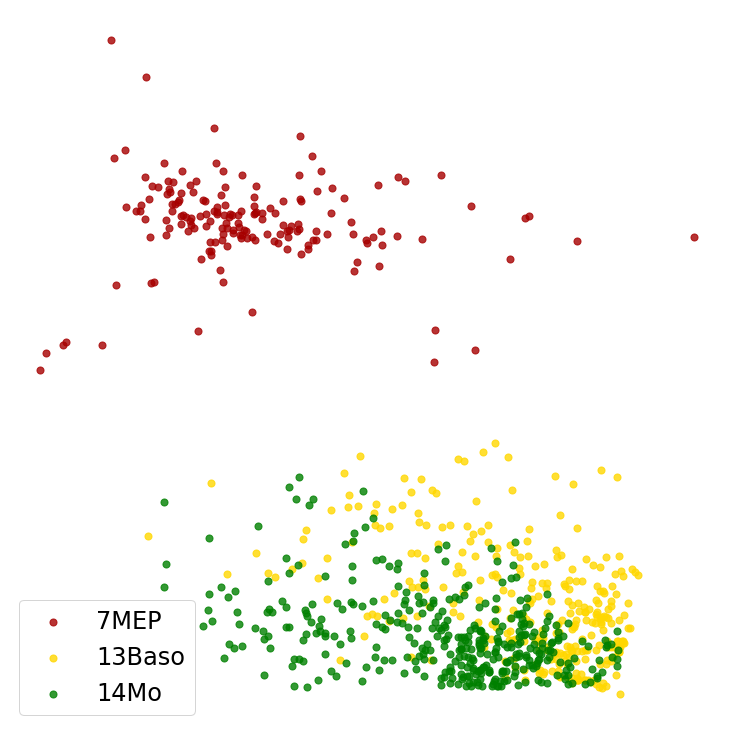

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Define alpha value
alpha = 0.8 

# Define colors for each class
L_hhh = [(0.65, 0.0, 0.0, alpha)] * len(z_hhh_class1) + [(1.0, 0.843, 0.0, alpha)] * len(z_hhh_class2) + [(0.0, 0.5, 0.0, alpha)] * len(z_hhh_class3)

# Plot points without frame or axes
plt.figure(figsize=(10, 10))
plt.scatter(np.array(z_hhh_class1)[:, 0], np.array(z_hhh_class1)[:, 1], s=50, color=(0.65, 0.0, 0.0, alpha), label='7MEP')
plt.scatter(np.array(z_hhh_class2)[:, 0], np.array(z_hhh_class2)[:, 1], s=50, color=(1.0, 0.843, 0.0, alpha), label='13Baso')
plt.scatter(np.array(z_hhh_class3)[:, 0], np.array(z_hhh_class3)[:, 1], s=50, color=(0.0, 0.5, 0.0, alpha), label='14Mo')

plt.axis('off')

# plt.legend(loc='best', fontsize=24)
plt.legend(loc='lower left', fontsize=24)


plt.tight_layout(pad=0)

plt.savefig('exp3_paul.png')
plt.savefig('exp3_paul.pdf')
plt.show()

In [80]:
    #need to normalize to get norms<1 in order to build the Hyperbolic Voronoi Diagram
    #small perturbation of 0.001 to not have the maximal norm being normalized to exactly 1 because all the normalized norms should be stricly inferior to 1   
    z_norms=[]
    pert = 0.001
    for v in z_hhh:
        z_norms.append(np.linalg.norm(v))
    max_z_norms = max(z_norms)+pert
    
    z_normalized=[]
    for i in range(len(z_hhh)):
            z_normalized.append([z_hhh[i][0]/max_z_norms, z_hhh[i][1]/max_z_norms])

    # z_normalized=np.array(z_normalized)

    #Convert from Poincaré to Beltrami-Cayley-Klein model latent representation
    z_beltrami = []
    for i in range(len(z_normalized)):
        norm_squared = z_normalized[i][0]**2+z_normalized[i][1]**2 
        z_beltrami.append([2*z_normalized[i][0]/(1+norm_squared), 2*z_normalized[i][1]/(1+norm_squared)])

    z_normalized=np.array(z_beltrami)
    
    z_beltrami_all = z_beltrami 

In [81]:
len_class1 = int(len(z_hhh_class1))
len_class2 = int(len(z_hhh_class2))
len_class3 = int(len(z_hhh_class3))

In [ ]:
# classes 1 and 2: 7MEP and 13Baso

In [1]:
z_normalized_list = z_beltrami_all[:(len_class1+len_class2)]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class1))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
#hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time) 
    
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
    
# If we are just interested in the global HyperDCA scores then we don't need to do the clustering so we can skip HDBSCAN and like if we have just one cluster
    
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class1))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# print('Preparing HyperDCA visualization...')
# visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)

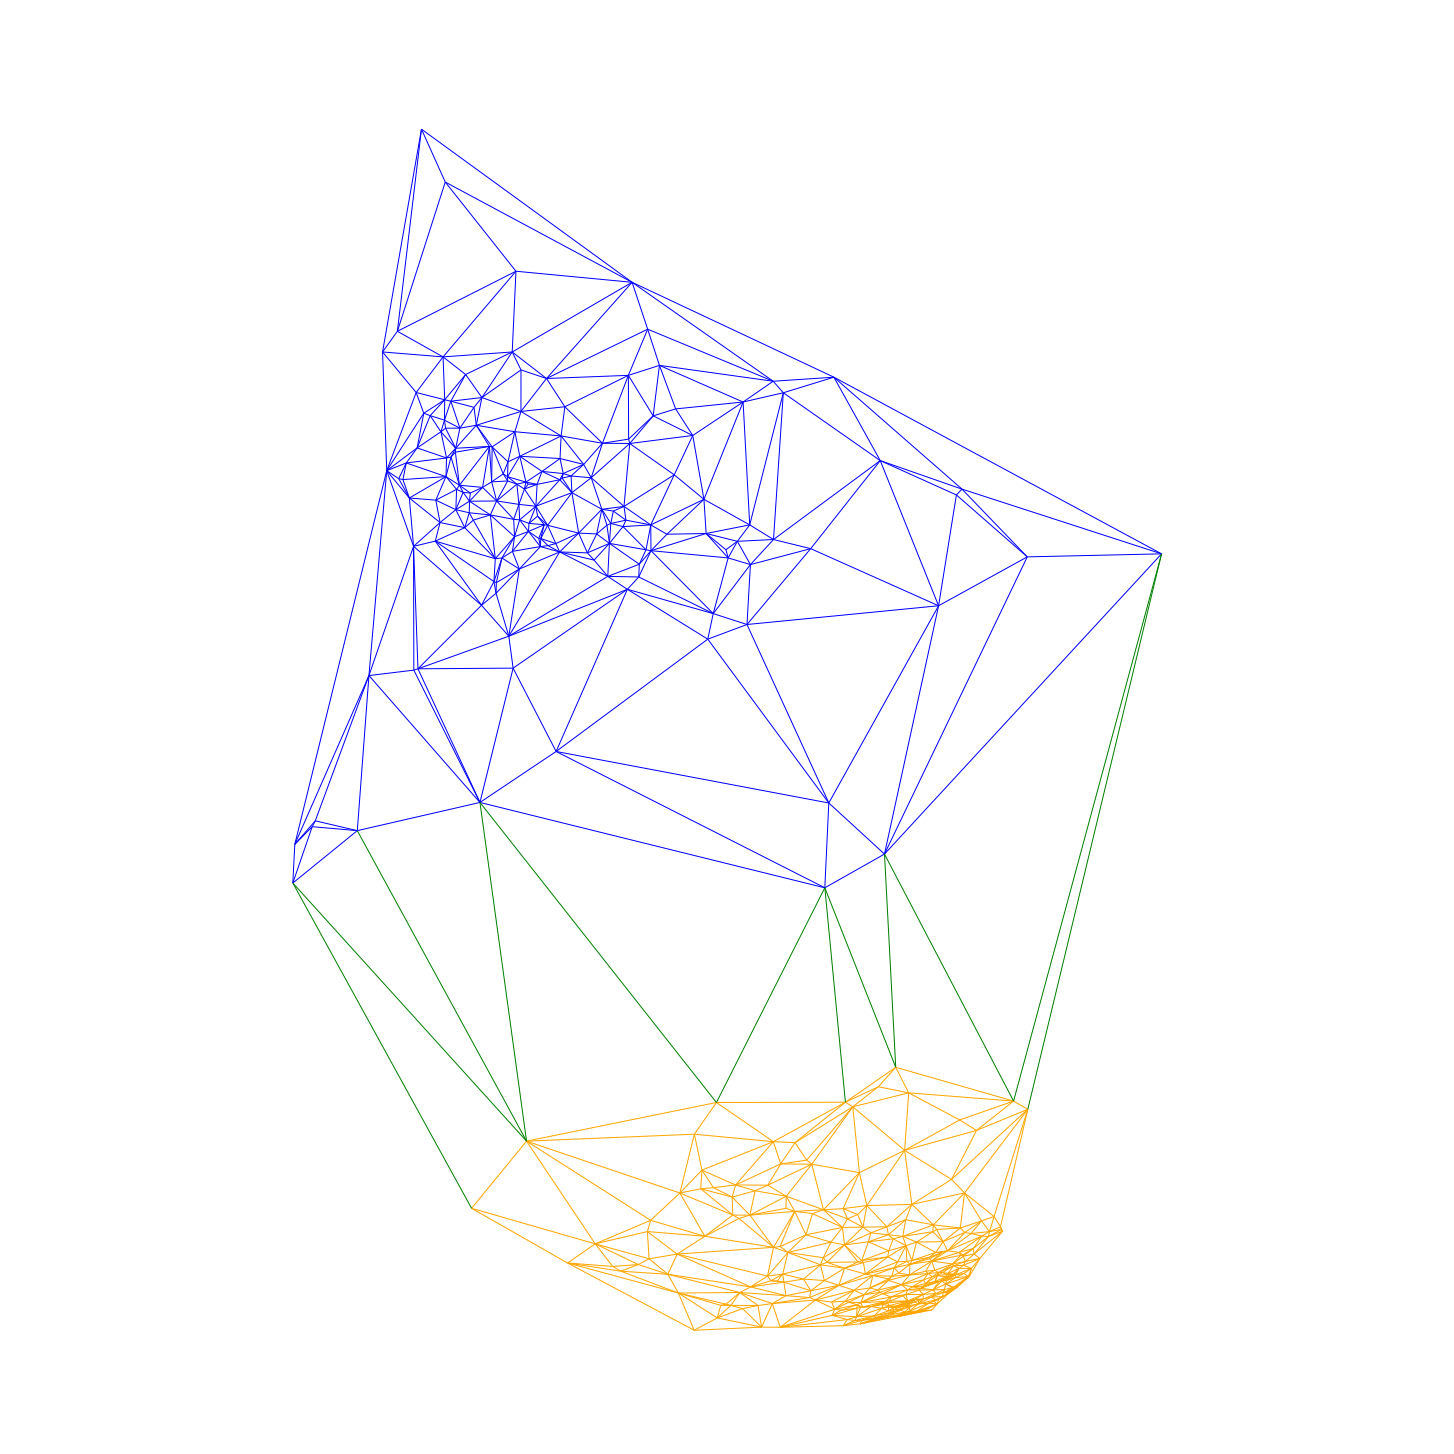

In [86]:
# ECML_exp3_Paul_7MEPVS13Baso
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [2]:
# classes 1 and 3: 7MEP and 14Mo

z_normalized_list = z_beltrami_all[:len_class1] + z_beltrami_all[(len_class1+len_class2):]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class1))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
end_time_cdist = time.time()

hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
end_time_chamfer = time.time()

hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
end_time_wasserstein = time.time()

elapsed_time_chamfer = end_time_chamfer - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time_chamfer) 
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

elapsed_time_wasserstein = end_time_wasserstein - end_time_chamfer + end_time_cdist-start_time
print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time_wasserstein) 
print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
    
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class1))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# print('Preparing HyperDCA visualization...')
# visualize(class1_label, class3_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))

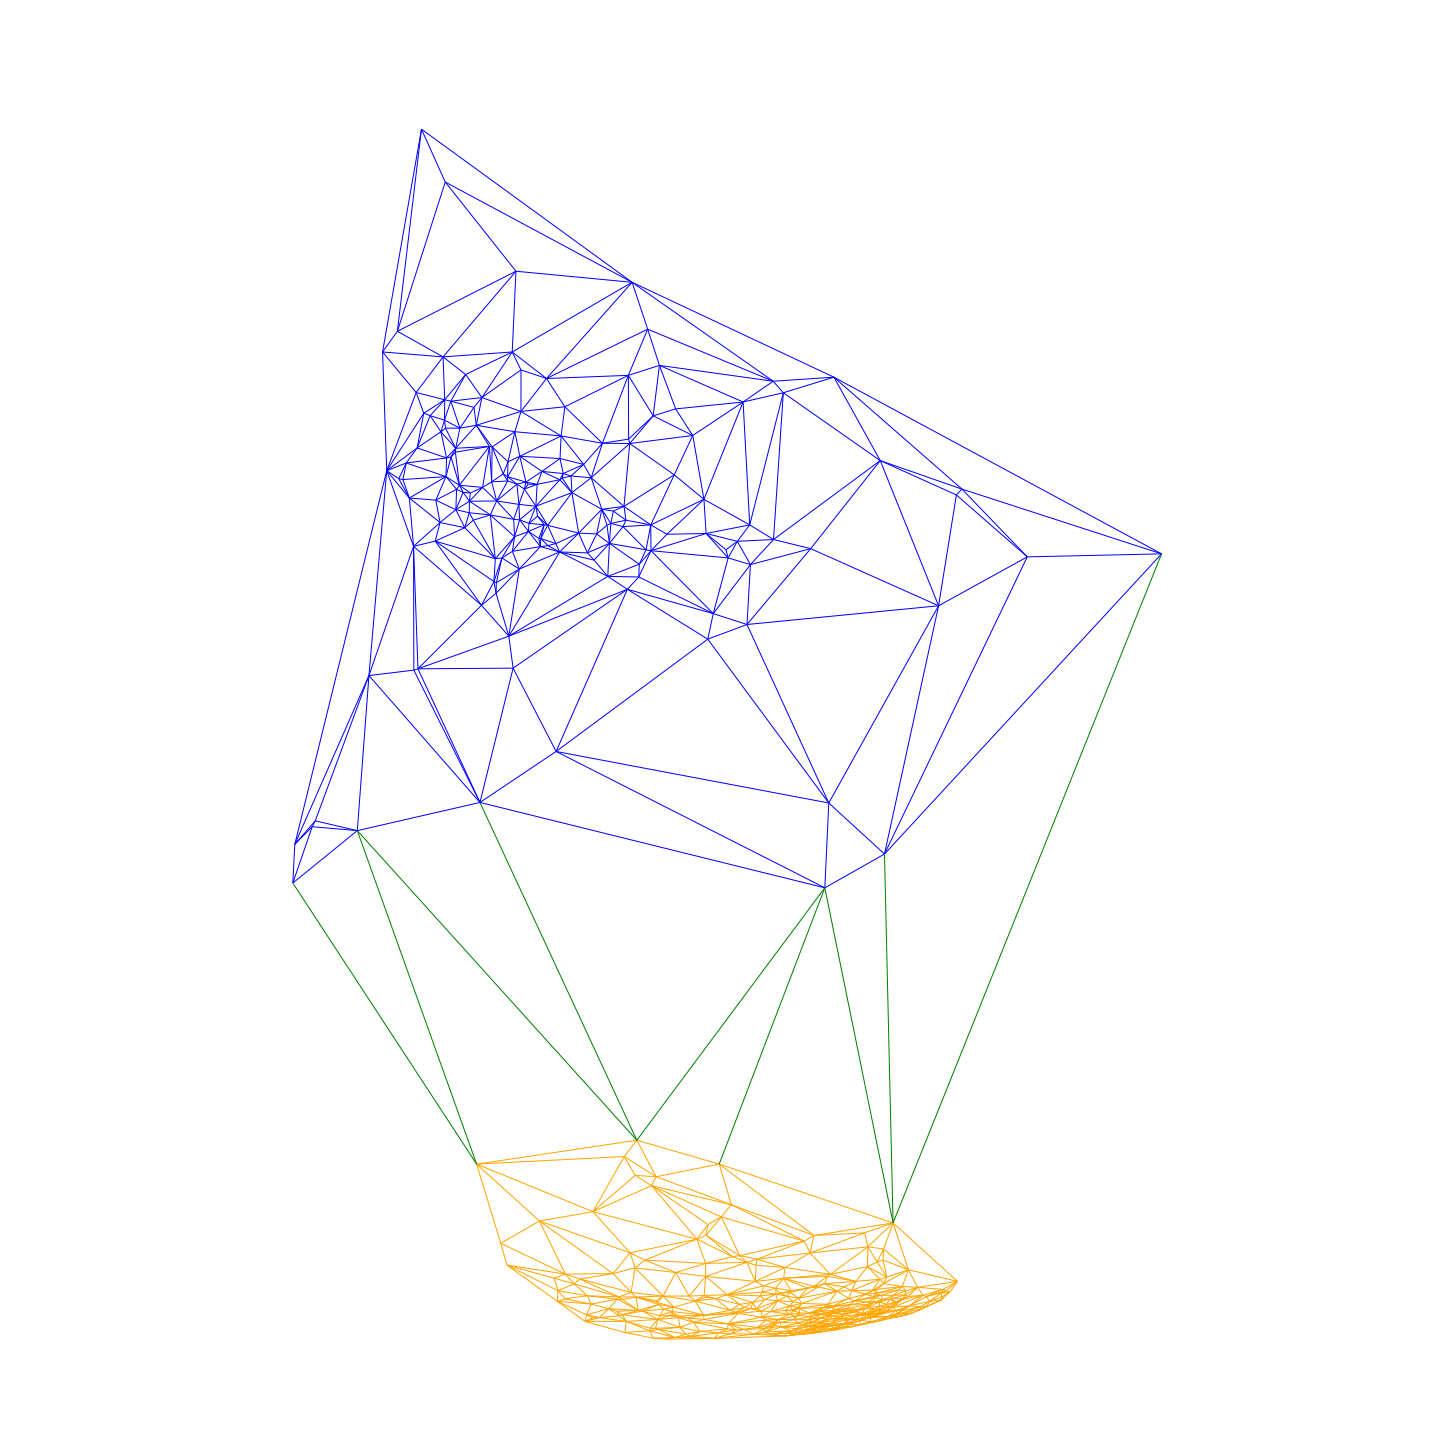

In [89]:
# ECML_exp3_Paul_7MEPVS14Mo
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [3]:
# classes 2 and 3: 13Baso and 14Mo

z_normalized_list = z_beltrami_all[len_class1:]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class2))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
end_time_cdist = time.time()

hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
end_time_chamfer = time.time()

hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
end_time_wasserstein = time.time()

elapsed_time_chamfer = end_time_chamfer - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time_chamfer) 
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

elapsed_time_wasserstein = end_time_wasserstein - end_time_chamfer + end_time_cdist-start_time
print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time_wasserstein) 
print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
   
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class2))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# print('Preparing HyperDCA visualization...')
# visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))

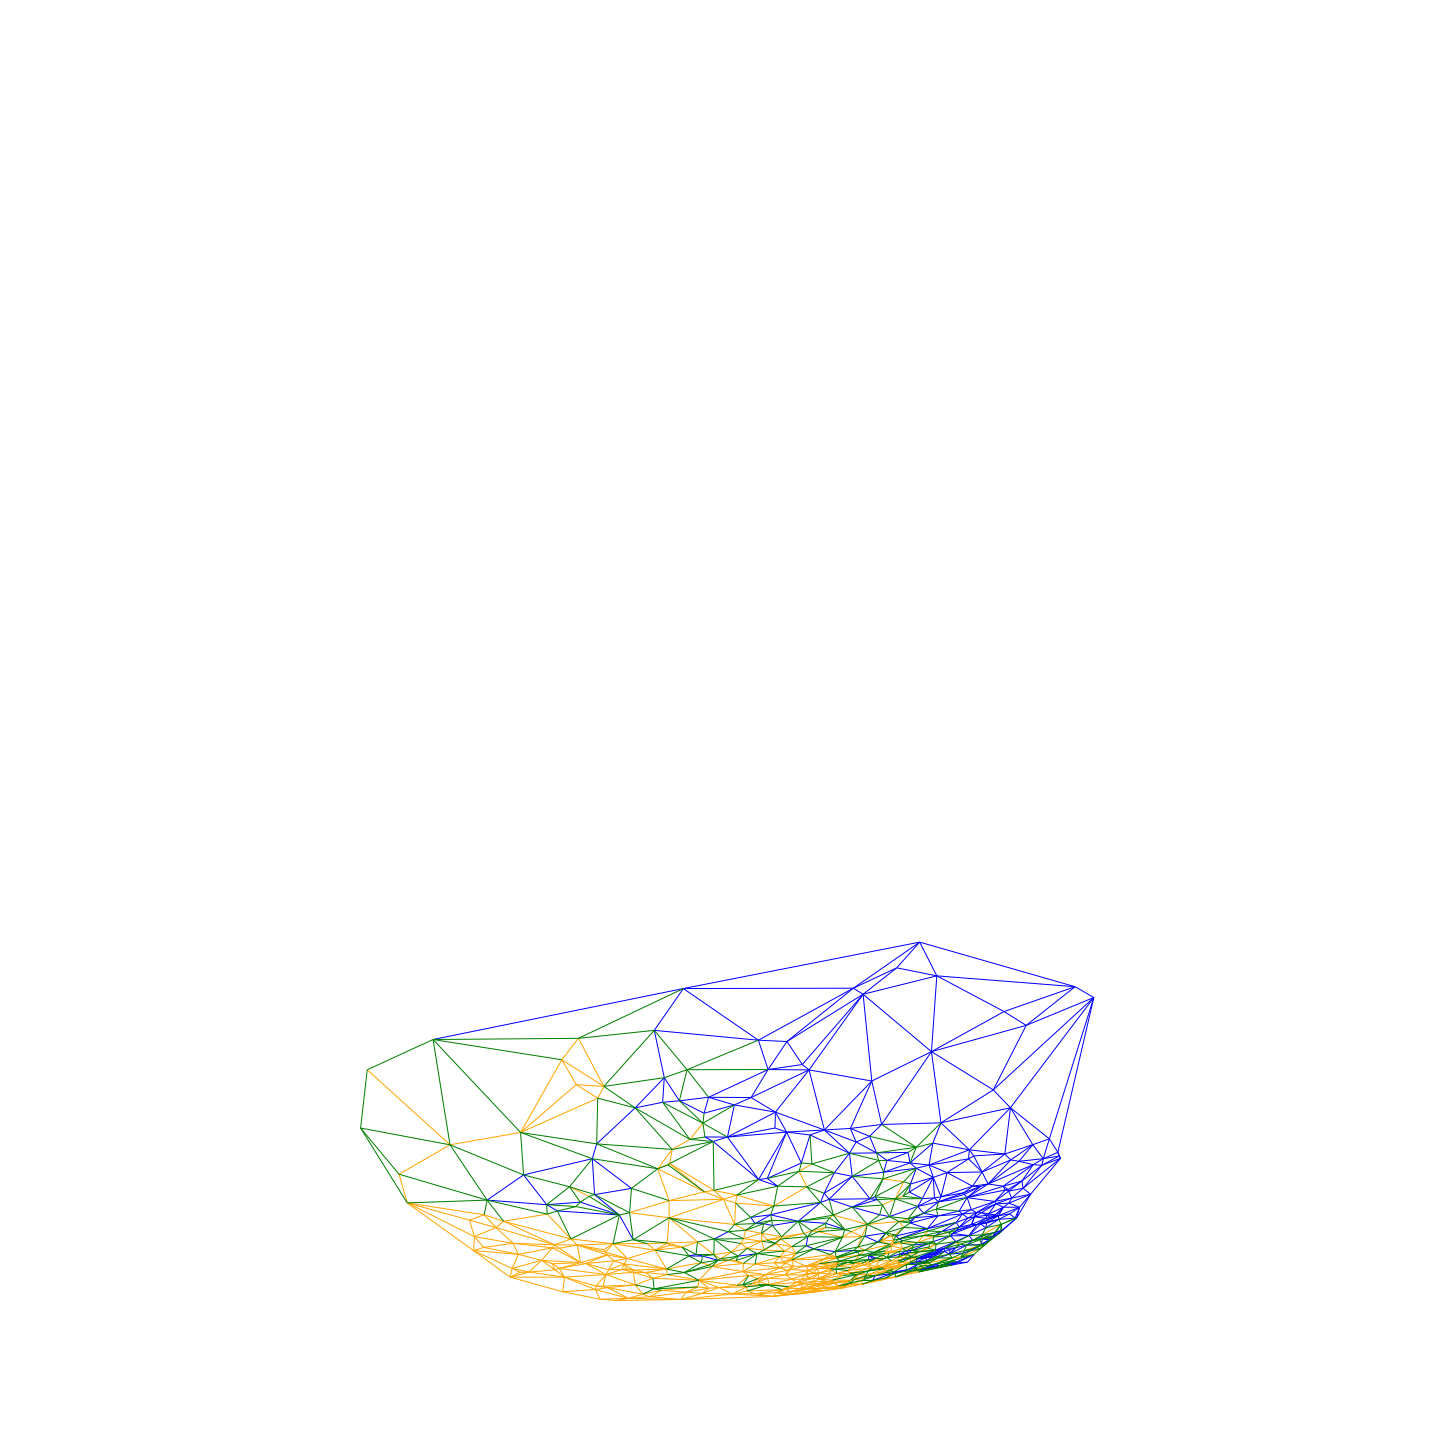

In [99]:
# ECML_exp3_Paul_13BasoVS14Mo
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [ ]:
########################
# Experiment with Olsson

In [267]:
dict_data_olsson.keys() 

dict_keys(['HSPC-1', 'HSPC-2', 'Meg', 'Eryth', 'Multi-Lin', 'MDP', 'Mono', 'Gran', 'Myelocyte'])

In [100]:
dict_data = dict_data_olsson 

In [112]:
class1_label = ['HSPC-1']
class2_label = ['Mono']
class3_label = ['Gran']

# #for a better visualization with colors:
# class3_label = ['Mono']
# class2_label = ['Gran']

z_hhh_class1 = []
for i in class1_label:
    z_hhh_class1 = z_hhh_class1 + dict_data[i]

z_hhh_class2 = []
for i in class2_label:
    z_hhh_class2 = z_hhh_class2 + dict_data[i]
    
z_hhh_class3 = []
for i in class3_label:
    z_hhh_class3 = z_hhh_class3 + dict_data[i]

z_hhh = z_hhh_class1 + z_hhh_class2 + z_hhh_class3

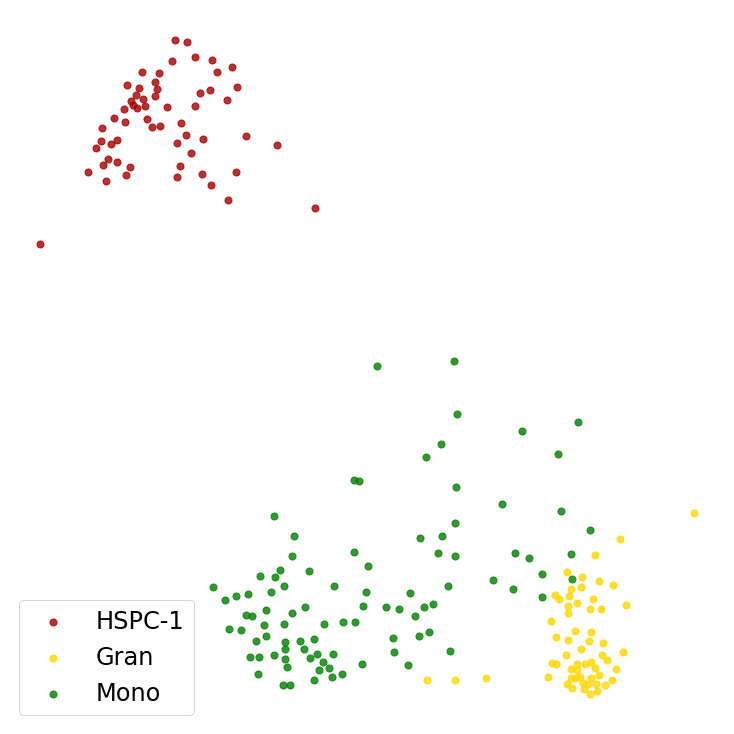

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Define alpha value
alpha = 0.8

# Define colors for each class
L_hhh = [(0.65, 0.0, 0.0, alpha)] * len(z_hhh_class1) + [(1.0, 0.843, 0.0, alpha)] * len(z_hhh_class2) + [(0.0, 0.5, 0.0, alpha)] * len(z_hhh_class3)

# Plot points without frame or axes
plt.figure(figsize=(10, 10))
plt.scatter(np.array(z_hhh_class1)[:, 0], np.array(z_hhh_class1)[:, 1], s=50, color=(0.65, 0.0, 0.0, alpha), label='HSPC-1')
# plt.scatter(np.array(z_hhh_class2)[:, 0], np.array(z_hhh_class2)[:, 1], s=50, color=(1.0, 0.843, 0.0, alpha), label='Mono')
# plt.scatter(np.array(z_hhh_class3)[:, 0], np.array(z_hhh_class3)[:, 1], s=50, color=(0.0, 0.5, 0.0, alpha), label='Gran')
#for better visualization (spread group in green and localized one in yellow)
plt.scatter(np.array(z_hhh_class2)[:, 0], np.array(z_hhh_class2)[:, 1], s=50, color=(1.0, 0.843, 0.0, alpha), label='Gran')
plt.scatter(np.array(z_hhh_class3)[:, 0], np.array(z_hhh_class3)[:, 1], s=50, color=(0.0, 0.5, 0.0, alpha), label='Mono')

plt.axis('off')

# plt.legend(loc='best', fontsize=24)
plt.legend(loc='lower left', fontsize=24)

plt.tight_layout(pad=0)
plt.savefig('exp3_olsson.png')
plt.savefig('exp3_olsson.pdf')
plt.show()

In [113]:
    #need to normalize to get norms<1 in order to build the Hyperbolic Voronoi Diagram
    z_norms=[]
    for v in z_hhh:
        z_norms.append(np.linalg.norm(v))
    max_z_norms = max(z_norms)+0.1#0.001 #small perturbation of 0.001 to not have the maximal norm being normalized to exactly 1 because all the normalized norms should be stricly inferior to 1   

    z_normalized=[]
    for i in range(len(z_hhh)):
            z_normalized.append([z_hhh[i][0]/max_z_norms, z_hhh[i][1]/max_z_norms])

    # z_normalized=np.array(z_normalized)

    #Convert from Poincaré to Beltrami-Cayley-Klein model latent representation
    z_beltrami = []
    for i in range(len(z_normalized)):
        norm_squared = z_normalized[i][0]**2+z_normalized[i][1]**2 
        z_beltrami.append([2*z_normalized[i][0]/(1+norm_squared), 2*z_normalized[i][1]/(1+norm_squared)])

    z_normalized=np.array(z_beltrami)
    
    z_beltrami_all = z_beltrami 

In [114]:
len_class1 = int(len(z_hhh_class1))
len_class2 = int(len(z_hhh_class2))
len_class3 = int(len(z_hhh_class3))

In [4]:
# class1_label = ['HSPC-1']
# class2_label = ['Mono']

#z_normalized_list = z_beltrami_all[:len_class1] + z_beltrami_all[(len_class1+len_class2):]
z_normalized_list = z_beltrami_all[:(len_class1+len_class2)]

z_normalized=np.array(z_normalized_list)

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class1))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Wasserstein distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
#hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time) 
    
print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


In [5]:
#classes 1 and 2
# class1_label = ['HSPC-1']
# class2_label = ['Mono']

z_normalized_list = z_beltrami_all[:(len_class1+len_class2)]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class1))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
#hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time) 
    
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
    
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class1))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# print('Preparing HyperDCA visualization...')
# visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)

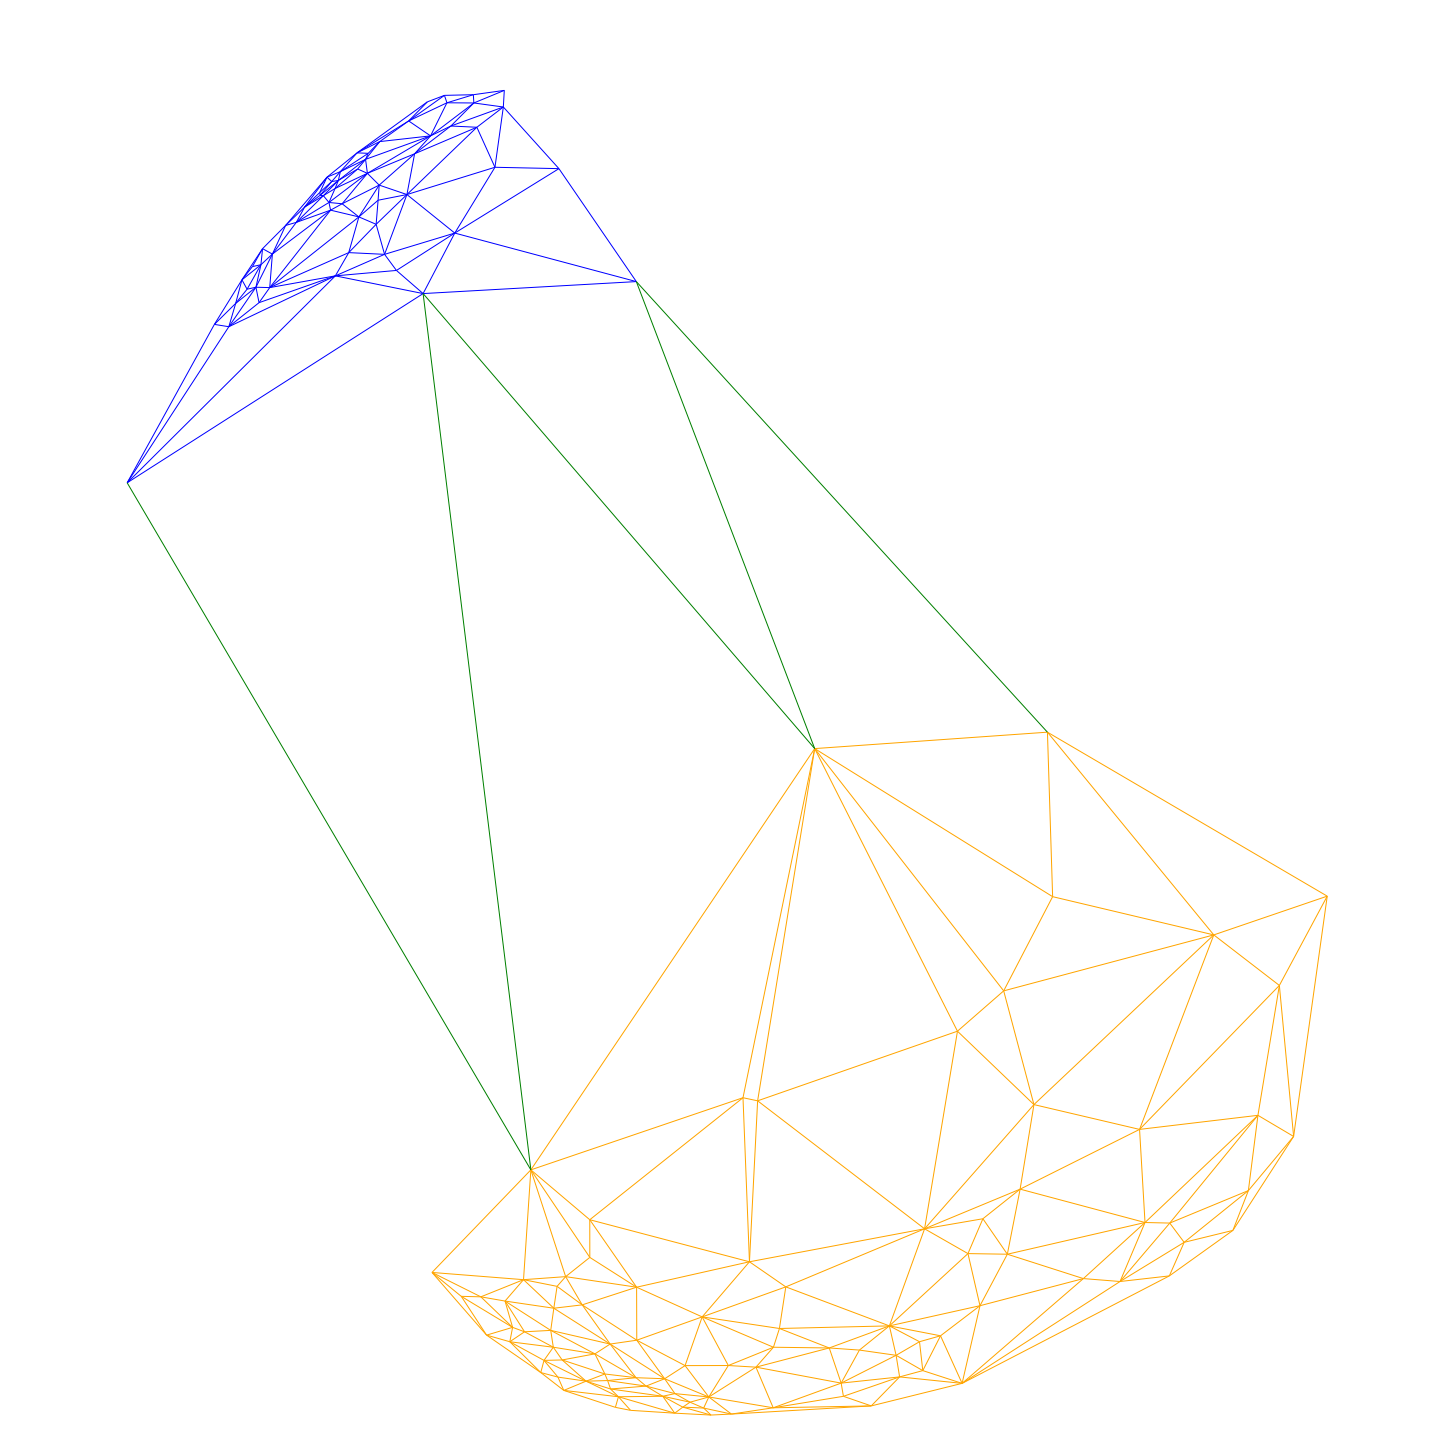

In [131]:
# ECML_exp3_Olsson_HSPC1VSMono
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [6]:
#classes 1 and 3: HSPC and Gran
    
z_normalized_list = z_beltrami_all[:len_class1] + z_beltrami_all[(len_class1+len_class2):]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class1))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
end_time_cdist = time.time()

hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
end_time_chamfer = time.time()

hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
end_time_wasserstein = time.time()

elapsed_time_chamfer = end_time_chamfer - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time_chamfer) 
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

elapsed_time_wasserstein = end_time_wasserstein - end_time_chamfer + end_time_cdist-start_time
print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time_wasserstein) 
print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################    
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class1))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# print('Preparing HyperDCA visualization...')
# visualize(class1_label, class3_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))

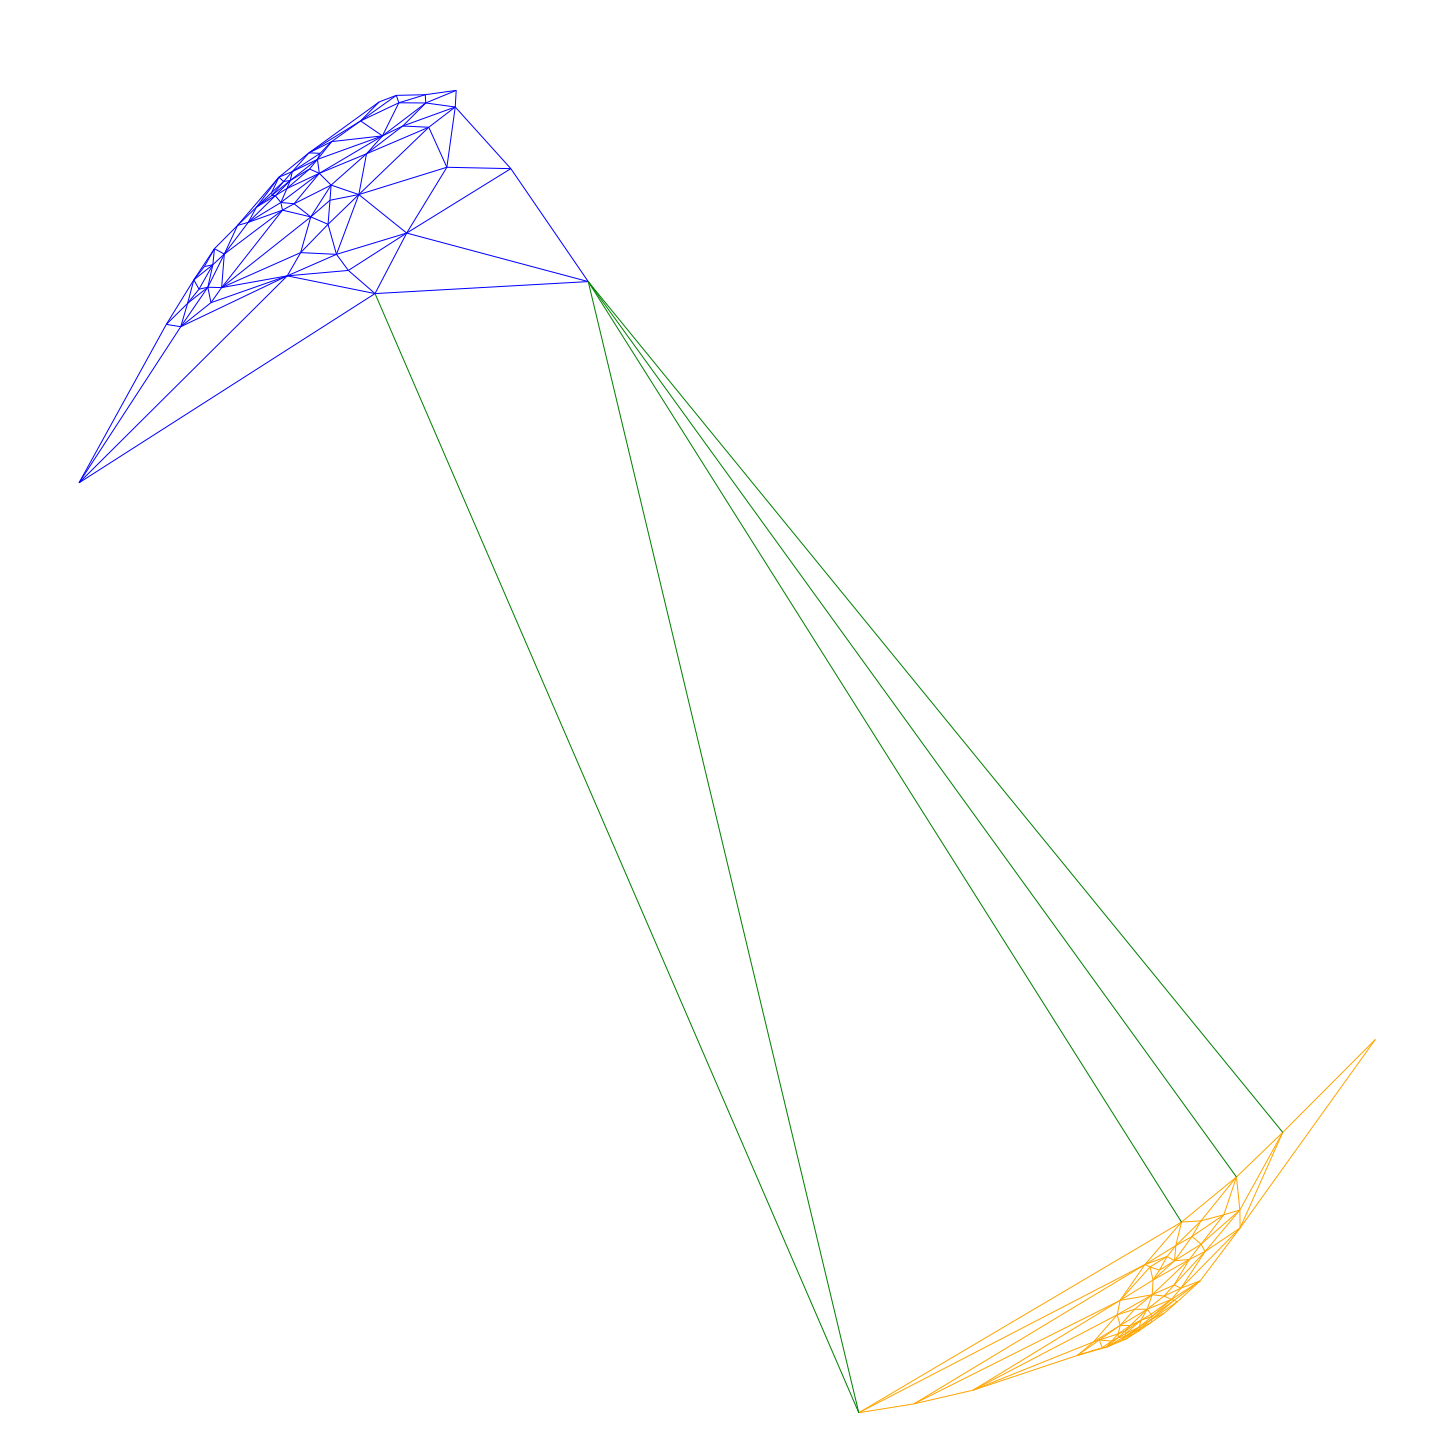

In [134]:
# ECML_exp3_Olsson_HSPC1VSGran
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [7]:
#new classes 2 and 3: Mono and Gran

z_normalized_list = z_beltrami_all[len_class1:]
z_normalized=np.array(z_normalized_list)
    
    

# Start timer
start_time = time.time()


threshold = int(len(z_hhh_class2))
A = z_normalized[:threshold]
B = z_normalized[threshold:]
    
print('Computing the Hyperbolic Chamfer distance...')
hyperbolic_cdistance = hyperbolic_cdist(A,B)
end_time_cdist = time.time()

hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
end_time_chamfer = time.time()

hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
end_time_wasserstein = time.time()

elapsed_time_chamfer = end_time_chamfer - start_time
print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time_chamfer) 
print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

elapsed_time_wasserstein = end_time_wasserstein - end_time_chamfer + end_time_cdist-start_time
print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time_wasserstein) 
print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


#####################
    
# Start timer
start_time = time.time()    
    
#Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
print('Computing the Hyperbolic Delaunay...')
    
S = np.array(z_normalized)

centers = np.zeros(S.shape)
radii = np.zeros(S.shape[0])

for i in range(S.shape[0]):
    ###To get hyperbolic Delaunay:
    centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
    radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

    ###To get Euclidean Delaunay:
    #centers[i] = S[i] 



# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(centers, radii)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

edge_map = get_edge_map(tri_list) ##
#edges = convert_tri_list_to_edges(tri_list)
edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
clusterer_labels = [0]*len(z_normalized_list)
    
distillation_delaunay = distillation(edges_real, clusterer_labels)
distilled_delaunay = distillation_delaunay['distilled_delaunay']
crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

threshold = int(len(z_hhh_class2))    #print(threshold)

R_indices = [i for i in range(threshold)]
E_indices=[i for i in range(threshold, z_normalized.shape[0])]
#Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

print('Computing HyperDCA scores')
scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for HyperDCA: ", elapsed_time)    
    
print('scores_dca_global: ', scores_dca_global)
    
# prinmt('Preparing HyperDCA visualization...')
# visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
#return scores_dca_global['quality'], hyperbolic_Chamfer_distance
print('HyperDCA global quality score: ', scores_dca_global['quality'])
print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)
print('hyperbolic_Wasserstein_distance pseudo-normalized: ', hyperbolic_Wasserstein_distance/len(z_normalized_list))


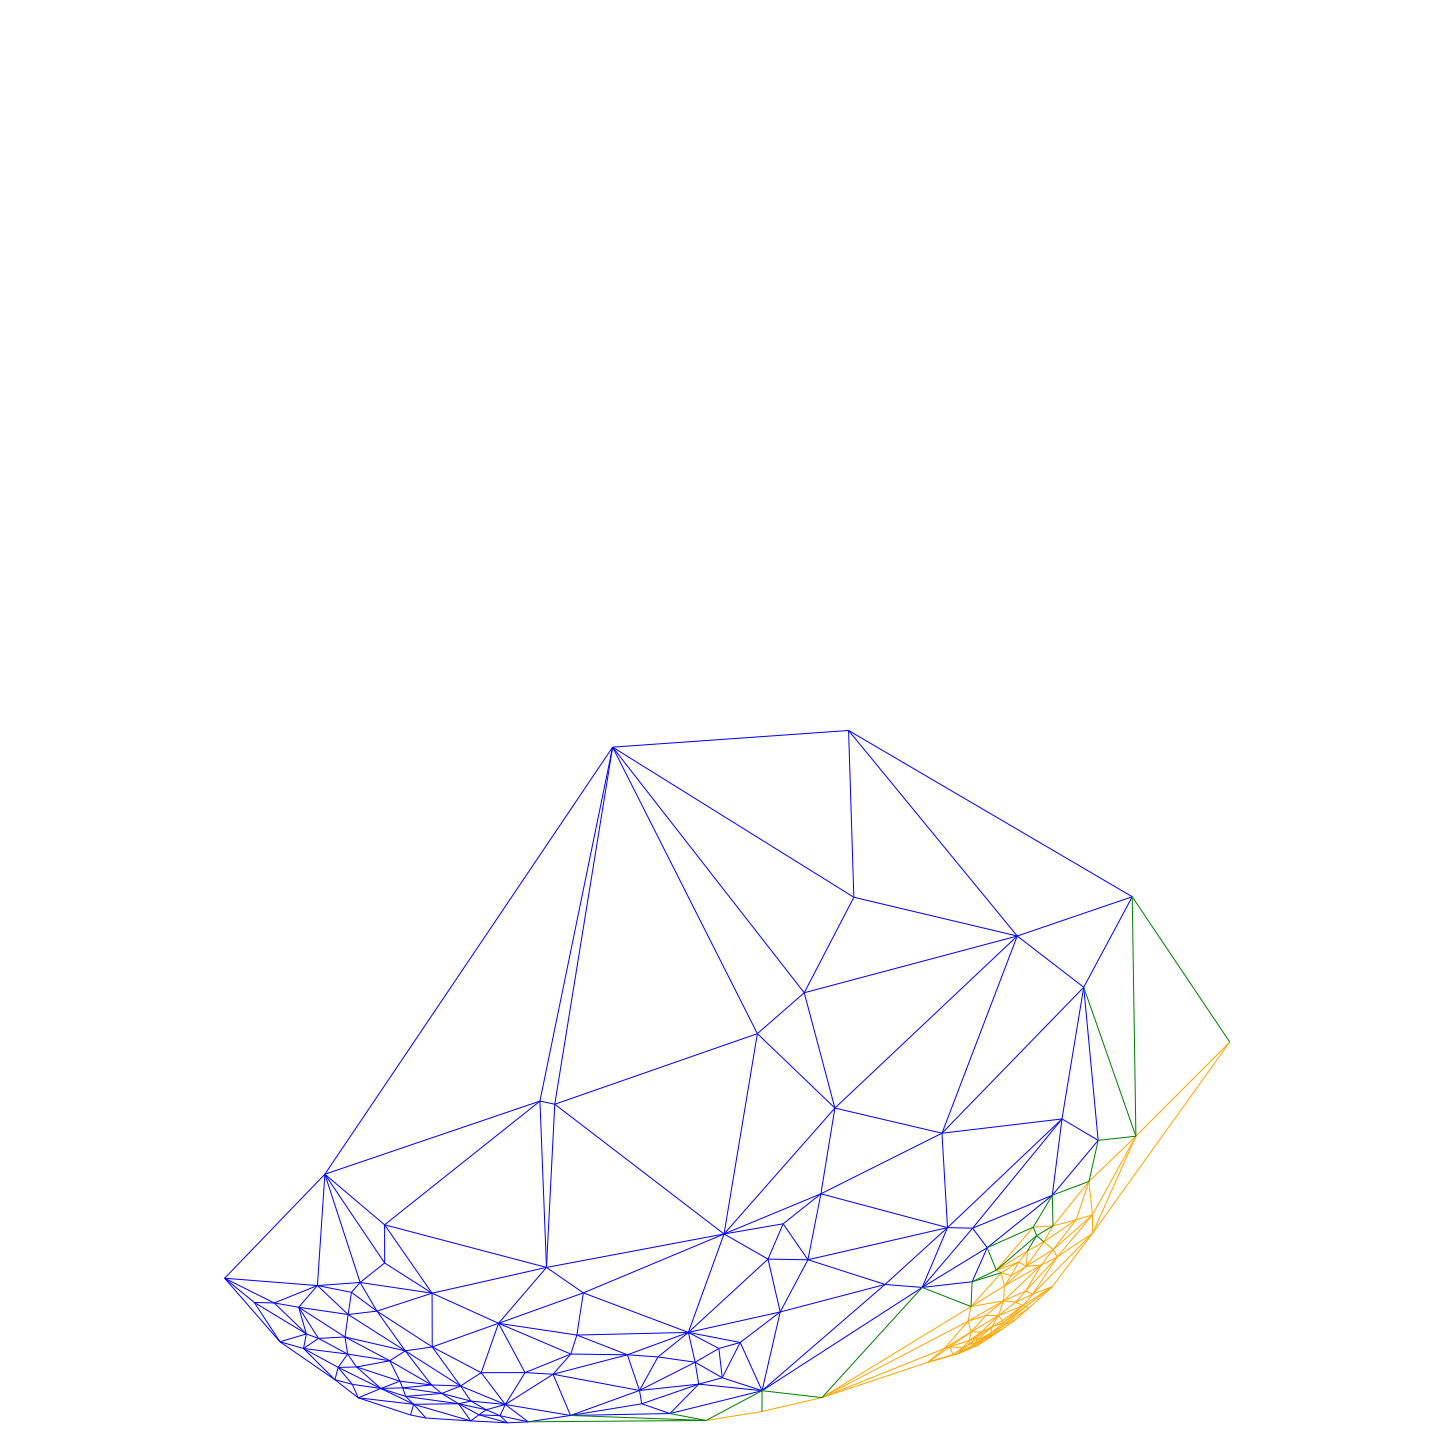

In [149]:
# ECML_exp3_Olsson_MonoVSGran
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='HyperDGA visualization in Klein') 

In [ ]:
########################
# Experiment with Planaria grouping into 3 groups: neoblasts, progenitors, differentiated cells

In [5]:
dict_data_planaria.keys() 

dict_keys(['secretory 1', 'psap+ parenchymal cells', 'late epidermal progenitors 1', 'neoblast 1', 'muscle body', 'early epidermal progenitors', 'secretory 4', 'epidermis', 'pgrn+ parenchymal cells', 'late epidermal progenitors 2', 'epidermis DVb', 'phagocytes', 'gut progenitors', 'ldlrr-1+ parenchymal cells', 'parenchymal progenitors', 'muscle progenitors', 'neoblast 10', 'otf+ cells 2', 'pigment', 'ChAT neurons 2', 'psd+ cells', 'aqp+ parenchymal cells', 'spp-11+ neurons', 'GABA neurons', 'pharynx cell type progenitors', 'otf+ cells 1', 'neural progenitors', 'epidermis DVb neoblast', 'goblet cells', 'muscle pharynx', 'npp-18+ neurons', 'ChAT neurons 1', 'pharynx cell type', 'neoblast 13', 'neoblast 6', 'neoblast 12', 'secretory 3', 'epidermal neoblasts', 'activated early epidermal progenitors', 'neoblast 9', 'neoblast 5', 'neoblast 4', 'cav-1+ neurons', 'secretory 2', 'neoblast 11', 'neoblast 8', 'neoblast 3', 'protonephridia', 'neoblast 7', 'neoblast 2', 'glia'])

In [6]:
# Neoblast (stem cells) VS Progenitors VS Differentiated cells

neoblasts = ['epidermis DVb neoblast', 'neoblast 1', 'neoblast 2', 'neoblast 3','neoblast 4','neoblast 5','neoblast 6','neoblast 7','neoblast 8','neoblast 9','neoblast 10','neoblast 11','neoblast 12','neoblast 13'] 
progenitors = ['epidermal neoblasts', 'early epidermal progenitors', 'gut progenitors', 'parenchymal progenitors', 'muscle progenitors', 'neural progenitors', 'activated early epidermal progenitors', ]
differentiated = ['pharynx cell type progenitors', 'late epidermal progenitors 1', 'late epidermal progenitors 2', 'secretory 1', 'psap+ parenchymal cells', 'muscle body', 'secretory 4', 'epidermis', 'pgrn+ parenchymal cells', 'epidermis DVb', 'phagocytes', 'ldlrr-1+ parenchymal cells', 'otf+ cells 2', 'pigment', 'ChAT neurons 2', 'psd+ cells', 'aqp+ parenchymal cells', 'spp-11+ neurons', 'GABA neurons', 'otf+ cells 1', 'goblet cells', 'muscle pharynx', 'npp-18+ neurons', 'ChAT neurons 1', 'pharynx cell type', 'secretory 3', 'cav-1+ neurons', 'secretory 2', 'protonephridia', 'glia']   

In [7]:
class1_label = neoblasts
class2_label = progenitors
class3_label = differentiated

z_hhh_class1 = []
for i in class1_label:
    z_hhh_class1 = z_hhh_class1 + dict_data_planaria[i]

z_hhh_class2 = []
for i in class2_label:
    z_hhh_class2 = z_hhh_class2 + dict_data_planaria[i]
    
z_hhh_class3 = []
for i in class3_label:
    z_hhh_class3 = z_hhh_class3 + dict_data_planaria[i]

z_hhh = z_hhh_class1 + z_hhh_class2 + z_hhh_class3

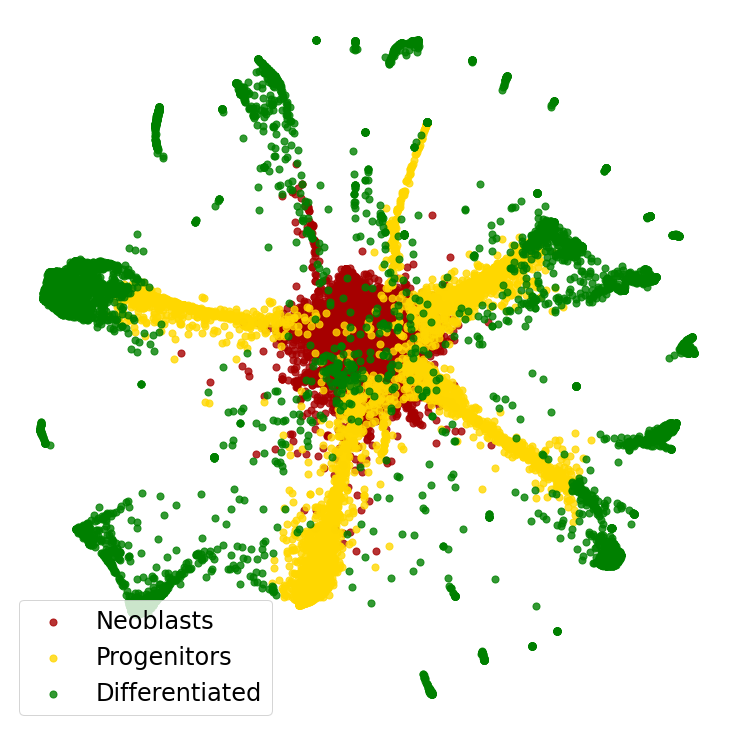

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define alpha value
alpha = 0.8

# Define colors for each class
L_hhh = [(0.65, 0.0, 0.0, alpha)] * len(z_hhh_class1) + [(1.0, 0.843, 0.0, alpha)] * len(z_hhh_class2) + [(0.0, 0.5, 0.0, alpha)] * len(z_hhh_class3)

# Plot points without frame or axes
plt.figure(figsize=(10, 10))
plt.scatter(np.array(z_hhh_class1)[:, 0], np.array(z_hhh_class1)[:, 1], s=50, color=(0.65, 0.0, 0.0, alpha), label='Neoblasts')
plt.scatter(np.array(z_hhh_class2)[:, 0], np.array(z_hhh_class2)[:, 1], s=50, color=(1.0, 0.843, 0.0, alpha), label='Progenitors')
plt.scatter(np.array(z_hhh_class3)[:, 0], np.array(z_hhh_class3)[:, 1], s=50, color=(0.0, 0.5, 0.0, alpha), label='Differentiated')

plt.axis('off')

plt.legend(loc='lower left', fontsize=24)

plt.tight_layout(pad=0)

plt.savefig('exp3_planaria.png')
plt.savefig('exp3_planaria.pdf')
plt.show()

In [8]:
    #need to normalize to get norms<1 in order to build the Hyperbolic Voronoi Diagram
    z_norms=[]
    for v in z_hhh:
        z_norms.append(np.linalg.norm(v))
    max_z_norms = max(z_norms)+0.001 #small perturbation of 0.001 to not have the maximal norm being normalized to exactly 1 because all the normalized norms should be stricly inferior to 1   

    z_normalized=[]
    for i in range(len(z_hhh)):
            z_normalized.append([z_hhh[i][0]/max_z_norms, z_hhh[i][1]/max_z_norms])

    # z_normalized=np.array(z_normalized)

    #Convert from Poincaré to Beltrami-Cayley-Klein model latent representation
    z_beltrami = []
    for i in range(len(z_normalized)):
        norm_squared = z_normalized[i][0]**2+z_normalized[i][1]**2 
        z_beltrami.append([2*z_normalized[i][0]/(1+norm_squared), 2*z_normalized[i][1]/(1+norm_squared)])

    z_normalized=np.array(z_beltrami)
    
    z_beltrami_all = z_beltrami 

In [9]:
len_neoblasts = int(len(z_hhh_class1))
len_progenitors = int(len(z_hhh_class2))
len_differentiated = int(len(z_hhh_class3))

In [8]:
    class1_label = neoblasts
    class2_label = differentiated
    
    z_normalized_list = z_beltrami_all[:len_neoblasts] + z_beltrami_all[(len_neoblasts+len_progenitors):]
    z_normalized=np.array(z_normalized_list)
    
    

    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class1))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Wasserstein distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    #hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time) 
    
    print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)

In [9]:
    class1_label = neoblasts
    class2_label = differentiated
    
    z_normalized_list = z_beltrami_all[:len_neoblasts] + z_beltrami_all[(len_neoblasts+len_progenitors):]
    z_normalized=np.array(z_normalized_list)
    
    

    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class1))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Chamfer distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    #hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time) 
    
    print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

#####################
    
    # Start timer
    start_time = time.time()    
    
    #Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
    print('Computing the Hyperbolic Delaunay...')
    
    S = np.array(z_normalized)

    centers = np.zeros(S.shape)
    radii = np.zeros(S.shape[0])

    for i in range(S.shape[0]):
        ###To get hyperbolic Delaunay:
        centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
        radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

        ###To get Euclidean Delaunay:
        #centers[i] = S[i] 



    # Compute the power triangulation of the circles
    tri_list, V = get_power_triangulation(centers, radii)

    # Compute the Voronoi cells
    voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

    edge_map = get_edge_map(tri_list) ##
    #edges = convert_tri_list_to_edges(tri_list)
    edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################    
    clusterer_labels = [0]*len(z_normalized_list)
    
    distillation_delaunay = distillation(edges_real, clusterer_labels)
    distilled_delaunay = distillation_delaunay['distilled_delaunay']
    crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

    threshold = int(len(z_hhh_class1))    #print(threshold)

    R_indices = [i for i in range(threshold)]
    E_indices=[i for i in range(threshold, z_normalized.shape[0])]
    #Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

    print('Computing HyperDCA scores')
    scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
    scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for HyperDCA: ", elapsed_time)    
    
    print('scores_dca_global: ', scores_dca_global)
    
#     print('Preparing HyperDCA visualization...')
#     visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 
    
    #return scores_dca_global['quality'], hyperbolic_Chamfer_distance
    print('HyperDCA global quality score: ', scores_dca_global['quality'])
    print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
    print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)

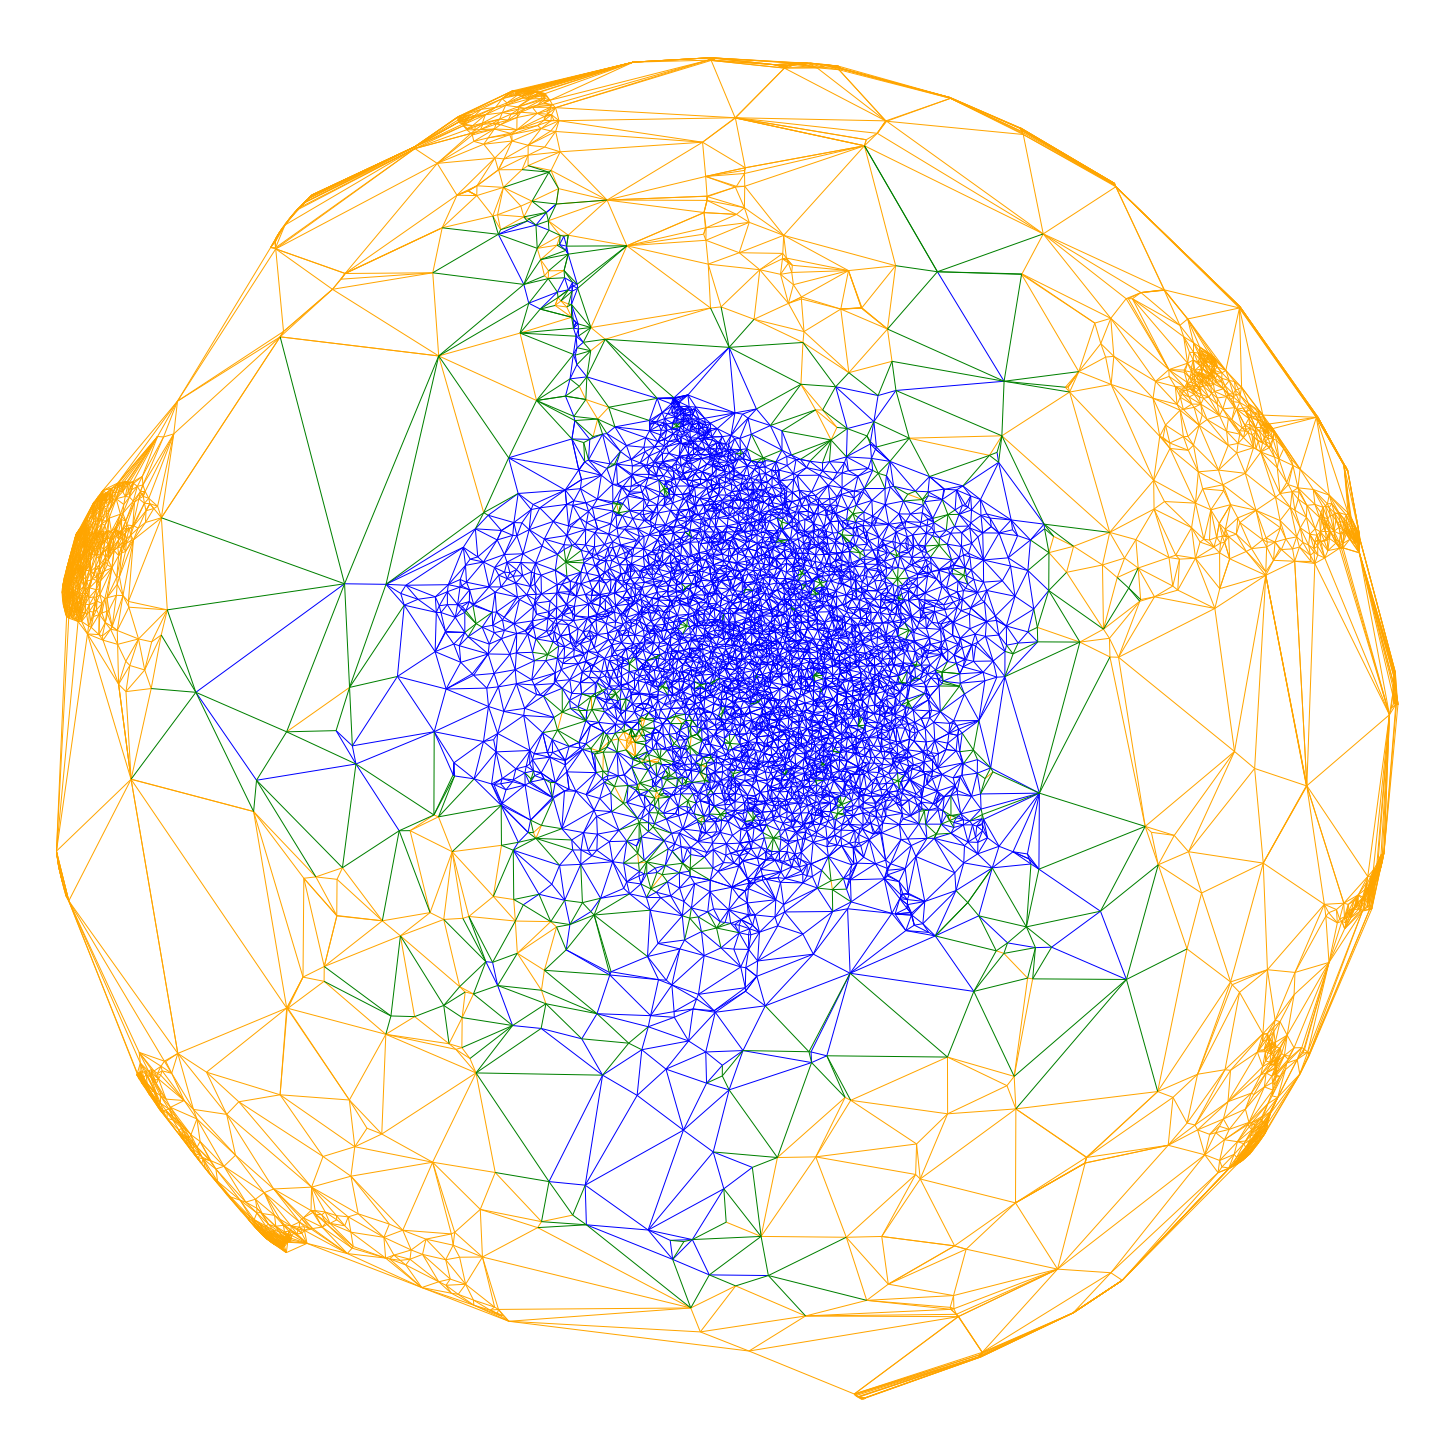

In [56]:
# NeoblastsVSDifferentiated
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='Hyperbolic DCA visualization of neoblasts versus differentiated cells in Klein') 

In [11]:
    class1_label = neoblasts
    class2_label = progenitors
    
    z_normalized_list = z_beltrami_all[:len_neoblasts+len_progenitors]
    z_normalized=np.array(z_normalized_list)
    


    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class1))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Wasserstein distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    #hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time) 
    
    print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)

Computing the Hyperbolic Wasserstein distance...
Elapsed time for Hyperbolic Wasserstein:  595.3498005867004
hyperbolic_Wasserstein_distance:  5821.127308977076


In [10]:
    class1_label = neoblasts
    class2_label = progenitors
    
    z_normalized_list = z_beltrami_all[:len_neoblasts+len_progenitors]
    z_normalized=np.array(z_normalized_list)
    


    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class1))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Chamfer distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    #hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time) 
    
    print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

#####################
    
    # Start timer
    start_time = time.time()    
    
    #Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
    print('Computing the Hyperbolic Delaunay...')
    
    S = np.array(z_normalized)

    centers = np.zeros(S.shape)
    radii = np.zeros(S.shape[0])

    for i in range(S.shape[0]):
        ###To get hyperbolic Delaunay:
        centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
        radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

        ###To get Euclidean Delaunay:
        #centers[i] = S[i] 



    # Compute the power triangulation of the circles
    tri_list, V = get_power_triangulation(centers, radii)

    # Compute the Voronoi cells
    voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

    edge_map = get_edge_map(tri_list) ##
    #edges = convert_tri_list_to_edges(tri_list)
    edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################ 
    clusterer_labels = [0]*len(z_normalized_list)
    
    distillation_delaunay = distillation(edges_real, clusterer_labels)
    distilled_delaunay = distillation_delaunay['distilled_delaunay']
    crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

    threshold = int(len(z_hhh_class1))    #print(threshold)

    R_indices = [i for i in range(threshold)]
    E_indices=[i for i in range(threshold, z_normalized.shape[0])]
    #Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

    print('Computing HyperDCA scores')
    scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
    scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for HyperDCA: ", elapsed_time)    
    
    print('scores_dca_global: ', scores_dca_global)
    
#     print('Preparing HyperDCA visualization...')
# #    visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of neoblasts versus progenitors in Klein') 
    
    #return scores_dca_global['quality'], hyperbolic_Chamfer_distance
    print('HyperDCA global quality score: ', scores_dca_global['quality'])
    print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
    print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)

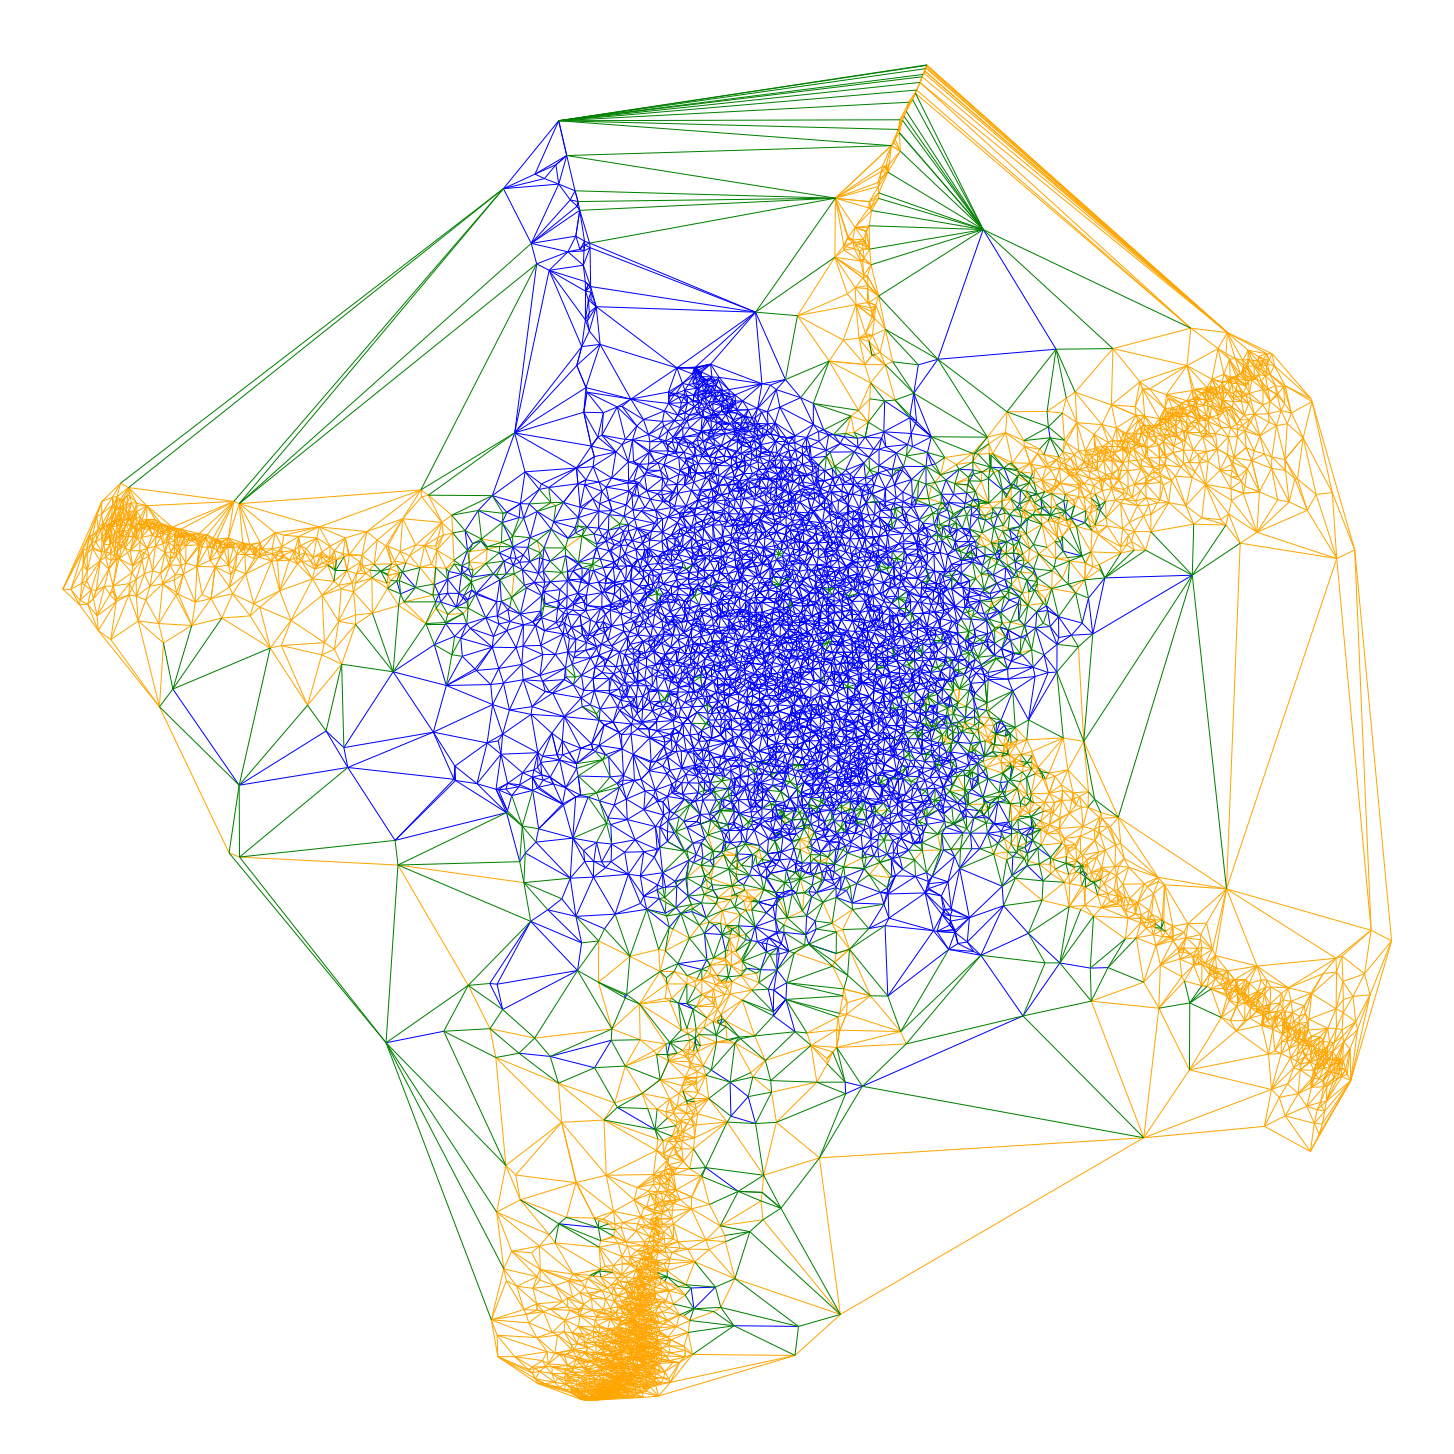

In [59]:
# NeoblastsVSProgenitors
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='Hyperbolic DCA visualization of neoblasts versus progenitors cells in Klein') 

In [11]:
    class1_label = progenitors
    class2_label = differentiated
    
    z_normalized_list = z_beltrami_all[len_neoblasts:]
    z_normalized=np.array(z_normalized_list)
    


    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class2))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Wasserstein distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    #hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Wasserstein: ", elapsed_time) 
    
    print('hyperbolic_Wasserstein_distance: ', hyperbolic_Wasserstein_distance)


In [12]:
    class1_label = progenitors
    class2_label = differentiated
    
    z_normalized_list = z_beltrami_all[len_neoblasts:]
    z_normalized=np.array(z_normalized_list)
    


    # Start timer
    start_time = time.time()


    threshold = int(len(z_hhh_class2))
    A = z_normalized[:threshold]
    B = z_normalized[threshold:]
    
    print('Computing the Hyperbolic Chamfer distance...')
    hyperbolic_cdistance = hyperbolic_cdist(A,B)
    #hyperbolic_Wasserstein_distance = hyperbolic_Wasserstein_dist(A,B, hyperbolic_cdistance) 
    hyperbolic_Chamfer_distance = hyperbolic_Chamfer_dist(A,B, hyperbolic_cdistance)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for Hyperbolic Chamfer: ", elapsed_time) 
    
    print('hyperbolic_Chamfer_distance: ', hyperbolic_Chamfer_distance)

#####################
    
    # Start timer
    start_time = time.time()    
    
    #Compute the hyperbolic (or Euclidean) Voronoi and Delaunay Complex
    print('Computing the Hyperbolic Delaunay...')
    
    S = np.array(z_normalized)

    centers = np.zeros(S.shape)
    radii = np.zeros(S.shape[0])

    for i in range(S.shape[0]):
        ###To get hyperbolic Delaunay:
        centers[i] = S[i]/(2*np.sqrt(1-(np.linalg.norm(S[i]))**2))
        radii[i] = (np.linalg.norm(S[i]))**2/(4*(1-(np.linalg.norm(S[i]))**2))-1/np.sqrt(1-(np.linalg.norm(S[i]))**2)   

        ###To get Euclidean Delaunay:
        #centers[i] = S[i] 



    # Compute the power triangulation of the circles
    tri_list, V = get_power_triangulation(centers, radii)

    # Compute the Voronoi cells
    voronoi_cell_map = get_voronoi_cells(centers, V, tri_list)

    edge_map = get_edge_map(tri_list) ##
    #edges = convert_tri_list_to_edges(tri_list)
    edges_real = convert_tri_list_to_edges_real(tri_list, V, edge_map, voronoi_cell_map)
    
################
    clusterer_labels = [0]*len(z_normalized_list)
    
    distillation_delaunay = distillation(edges_real, clusterer_labels)
    distilled_delaunay = distillation_delaunay['distilled_delaunay']
    crossed_edges = distillation_delaunay['crossed_edges']
    
#######################

    threshold = int(len(z_hhh_class2))    #print(threshold)

    R_indices = [i for i in range(threshold)]
    E_indices=[i for i in range(threshold, z_normalized.shape[0])]
    #Be careful, the Delaunay built from z_normalized should be such that z_normalized=(R_indices U E_indices)  

    print('Computing HyperDCA scores')
    scores_dca_local, edges_family = eval_scores_dca_local(distilled_delaunay, clusterer_labels, R_indices, E_indices, get_edges_family = True)
########################
    
    scores_dca_global, edges_family = eval_scores_dca_global(scores_dca_local, 0.5, 0.3, R_indices, E_indices, crossed_edges, edges_real, edges_family, get_edges_family=True)
    
    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for HyperDCA: ", elapsed_time)    
    
    print('scores_dca_global: ', scores_dca_global)
    
#     print('Preparing HyperDCA visualization...')
#     visualize(class1_label, class2_label, S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.5, title='Hyperbolic DCA visualization of progenitors versus differentiated cells in Klein') 
    
    #return scores_dca_global['quality'], hyperbolic_Chamfer_distance
    print('HyperDCA global quality score: ', scores_dca_global['quality'])
    print('HyperDCA distance (1-hDCAglobalquality): ', 1-scores_dca_global['quality'])
    print('Hyperbolic Chamfer: ', hyperbolic_Chamfer_distance)

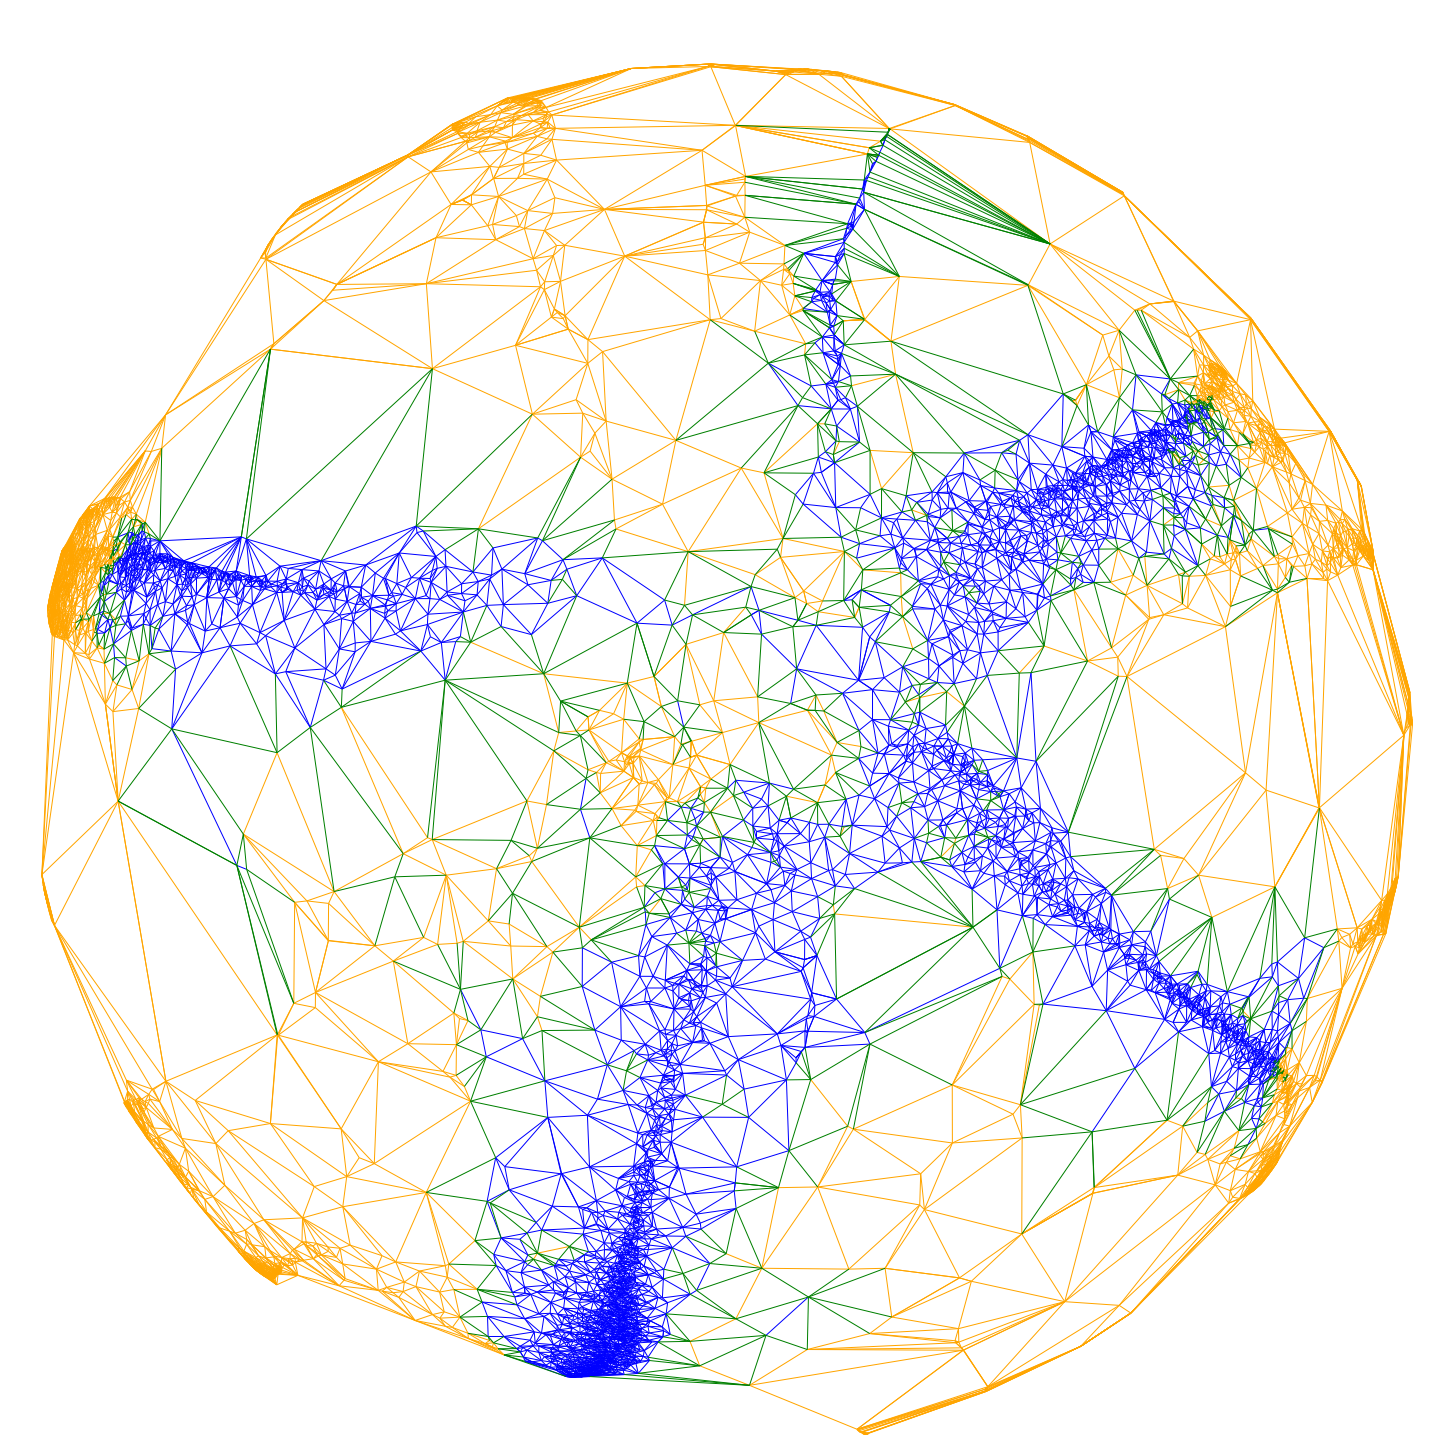

In [72]:
# ProgenitorsVSDifferentiated
visualize(S, R_indices, E_indices, voronoi_cell_map, edges_family, margen=0.0, title='Hyperbolic DCA visualization of progenitors versus differentiated cells in Klein') 